Thanks for:

https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

https://upura.hatenablog.com/entry/2019/03/03/233534


In [50]:
# Version = "v1": starter model
Version = "v2" # Add debug mode and minor modifications

In [51]:
DEBUG = True

# Library

In [52]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [53]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.moa.lgbm.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [54]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=50
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Threshold = 0.6
Max_depth = 7

# Data Loading

In [55]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [56]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [57]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    
    X_train = train.drop(["sig_id"], axis=1)
    y_train = train_targets_scored[target_col]
    X_test = test.drop(["sig_id"], axis=1)

    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))

    for fold_, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=10,
                          num_boost_round=1000,
                          early_stopping_rounds=10)


        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
        #logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return oof_train, sum(y_preds) / len(y_preds), models

In [58]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [59]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [60]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [61]:
train, test = label_encoding(train, test, ['cp_type', 'cp_dose'])

In [62]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# Modeling

In [63]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = ['cp_type', 'cp_dose']
oof = train_targets_scored.copy()
feature_importance_df = pd.DataFrame()
models = []

In [64]:
for target_col in tqdm(train_targets_scored.columns):
    if target_col != "sig_id":
        _oof, _preds, models = run_lgbm(target_col)
        oof[target_col] = _oof
        sub[target_col] = _preds
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = test.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

================================= fold 1/2 5-alpha_reductase_inhibitor=================================
================================= fold 1/2 5-alpha_reductase_inhibitor=================================
================================= fold 1/2 5-alpha_reductase_inhibitor=================================
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0021301	valid_1's binary_logloss: 0.00561024
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0052987	valid_1's binary_logloss: 0.00558749


================================= fold 2/2 5-alpha_reductase_inhibitor=================================
================================= fold 2/2 5-alpha_reductase_inhibitor=================================
================================= fold 2/2 5-alpha_reductase_inhibitor=================================
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00195161	valid_1's binary_logloss: 0.00624535
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00505257	valid_1's binary_logloss: 0.00619707


================================= fold 1/2 11-beta-hsd1_inhibitor=================================
================================= fold 1/2 11-beta-hsd1_inhibitor=================================
================================= fold 1/2 11-beta-hsd1_inhibitor=================================
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00222929	valid_1's binary_logloss: 0.0062506
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00528889	valid_1's binary_logloss: 0.0061952


================================= fold 2/2 11-beta-hsd1_inhibitor=================================
================================= fold 2/2 11-beta-hsd1_inhibitor=================================
================================= fold 2/2 11-beta-hsd1_inhibitor=================================
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00213853	valid_1's binary_logloss: 0.00623684
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00556059	valid_1's binary_logloss: 0.00619414


================================= fold 1/2 acat_inhibitor=================================
================================= fold 1/2 acat_inhibitor=================================
================================= fold 1/2 acat_inhibitor=================================
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00299678	valid_1's binary_logloss: 0.00797287
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00628035	valid_1's binary_logloss: 0.00793537


================================= fold 2/2 acat_inhibitor=================================
================================= fold 2/2 acat_inhibitor=================================
================================= fold 2/2 acat_inhibitor=================================
================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00331974	valid_1's binary_logloss: 0.00793496
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00517702	valid_1's binary_logloss: 0.0078987


================================= fold 1/2 acetylcholine_receptor_agonist=================================
================================= fold 1/2 acetylcholine_receptor_agonist=================================
================================= fold 1/2 acetylcholine_receptor_agonist=================================
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0304513	valid_1's binary_logloss: 0.0464554
[20]	training's binary_logloss: 0.0215885	valid_1's binary_logloss: 0.0461444
[30]	training's binary_logloss: 0.0166813	valid_1's binary_logloss: 0.045905
[40]	training's binary_logloss: 0.0135674	valid_1's binary_logloss: 0.045878
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0145749	valid_1's binary_logloss: 0.0458275


================================= fold 2/2 acetylcholine_receptor_agonist=================================
================================= fold 2/2 acetylcholine_receptor_agonist=================================
================================= fold 2/2 acetylcholine_receptor_agonist=================================
================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0318817	valid_1's binary_logloss: 0.0466874
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0448717	valid_1's binary_logloss: 0.0465583


================================= fold 1/2 acetylcholine_receptor_antagonist=================================
================================= fold 1/2 acetylcholine_receptor_antagonist=================================
================================= fold 1/2 acetylcholine_receptor_antagonist=================================
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0490974	valid_1's binary_logloss: 0.0672225
[20]	training's binary_logloss: 0.0375638	valid_1's binary_logloss: 0.0670189
[30]	training's binary_logloss: 0.0313649	valid_1's binary_logloss: 0.0667649
[40]	training's binary_logloss: 0.0263526	valid_1's binary_logloss: 0.0667487
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0290071	valid_1's binary_logloss: 0.0666118


================================= fold 2/2 acetylcholine_receptor_antagonist=================================
================================= fold 2/2 acetylcholine_receptor_antagonist=================================
================================= fold 2/2 acetylcholine_receptor_antagonist=================================
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0503341	valid_1's binary_logloss: 0.0675219
[20]	training's binary_logloss: 0.0377748	valid_1's binary_logloss: 0.0675826
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0503341	valid_1's binary_logloss: 0.0675219


================================= fold 1/2 acetylcholinesterase_inhibitor=================================
================================= fold 1/2 acetylcholinesterase_inhibitor=================================
================================= fold 1/2 acetylcholinesterase_inhibitor=================================
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00934194	valid_1's binary_logloss: 0.0205432
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0193573	valid_1's binary_logloss: 0.0205356


================================= fold 2/2 acetylcholinesterase_inhibitor=================================
================================= fold 2/2 acetylcholinesterase_inhibitor=================================
================================= fold 2/2 acetylcholinesterase_inhibitor=================================
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00883807	valid_1's binary_logloss: 0.021082
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0191005	valid_1's binary_logloss: 0.0210135


================================= fold 1/2 adenosine_receptor_agonist=================================
================================= fold 1/2 adenosine_receptor_agonist=================================
================================= fold 1/2 adenosine_receptor_agonist=================================
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00687058	valid_1's binary_logloss: 0.0161097
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00867386	valid_1's binary_logloss: 0.0160555


================================= fold 2/2 adenosine_receptor_agonist=================================
================================= fold 2/2 adenosine_receptor_agonist=================================
================================= fold 2/2 adenosine_receptor_agonist=================================
================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00657066	valid_1's binary_logloss: 0.0160658
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00700976	valid_1's binary_logloss: 0.0160492


================================= fold 1/2 adenosine_receptor_antagonist=================================
================================= fold 1/2 adenosine_receptor_antagonist=================================
================================= fold 1/2 adenosine_receptor_antagonist=================================
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0128108	valid_1's binary_logloss: 0.0264408
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0222102	valid_1's binary_logloss: 0.0263373


================================= fold 2/2 adenosine_receptor_antagonist=================================
================================= fold 2/2 adenosine_receptor_antagonist=================================
================================= fold 2/2 adenosine_receptor_antagonist=================================
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0128288	valid_1's binary_logloss: 0.0264365
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0242246	valid_1's binary_logloss: 0.0262788


================================= fold 1/2 adenylyl_cyclase_activator=================================
================================= fold 1/2 adenylyl_cyclase_activator=================================
================================= fold 1/2 adenylyl_cyclase_activator=================================
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00140702	valid_1's binary_logloss: 0.00401624
[20]	training's binary_logloss: 0.000869237	valid_1's binary_logloss: 0.00400746
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00107965	valid_1's binary_logloss: 0.00400055


================================= fold 2/2 adenylyl_cyclase_activator=================================
================================= fold 2/2 adenylyl_cyclase_activator=================================
================================= fold 2/2 adenylyl_cyclase_activator=================================
================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00152704	valid_1's binary_logloss: 0.00415562
[20]	training's binary_logloss: 0.00097481	valid_1's binary_logloss: 0.00406728
[30]	training's binary_logloss: 0.000671299	valid_1's binary_logloss: 0.0040035
[40]	training's binary_logloss: 0.00048848	valid_1's binary_logloss: 0.00396461
[50]	training's binary_logloss: 0.000365095	valid_1's binary_logloss: 0.00397592
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.000433436	valid_1's binary_logloss: 0.00396135


================================= fold 1/2 adrenergic_receptor_agonist=================================
================================= fold 1/2 adrenergic_receptor_agonist=================================
================================= fold 1/2 adrenergic_receptor_agonist=================================
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0402543	valid_1's binary_logloss: 0.0605894
[20]	training's binary_logloss: 0.0292411	valid_1's binary_logloss: 0.060334
[30]	training's binary_logloss: 0.0226989	valid_1's binary_logloss: 0.0601866
[40]	training's binary_logloss: 0.0184255	valid_1's binary_logloss: 0.0600313
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0192856	valid_1's binary_logloss: 0.059989


================================= fold 2/2 adrenergic_receptor_agonist=================================
================================= fold 2/2 adrenergic_receptor_agonist=================================
================================= fold 2/2 adrenergic_receptor_agonist=================================
================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0406241	valid_1's binary_logloss: 0.0614904
[20]	training's binary_logloss: 0.0299139	valid_1's binary_logloss: 0.0607701
[30]	training's binary_logloss: 0.0232972	valid_1's binary_logloss: 0.0604803
[40]	training's binary_logloss: 0.0188781	valid_1's binary_logloss: 0.0603564
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0223247	valid_1's binary_logloss: 0.0603305


================================= fold 1/2 adrenergic_receptor_antagonist=================================
================================= fold 1/2 adrenergic_receptor_antagonist=================================
================================= fold 1/2 adrenergic_receptor_antagonist=================================
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0639532	valid_1's binary_logloss: 0.0777226
[20]	training's binary_logloss: 0.0513572	valid_1's binary_logloss: 0.0774091
[30]	training's binary_logloss: 0.0428461	valid_1's binary_logloss: 0.0773991
[40]	training's binary_logloss: 0.0369576	valid_1's binary_logloss: 0.0772148
[50]	training's binary_logloss: 0.0314703	valid_1's binary_logloss: 0.077426
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0357696	valid_1's binary_logloss: 0.0771663


================================= fold 2/2 adrenergic_receptor_antagonist=================================
================================= fold 2/2 adrenergic_receptor_antagonist=================================
================================= fold 2/2 adrenergic_receptor_antagonist=================================
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0627671	valid_1's binary_logloss: 0.0777495
[20]	training's binary_logloss: 0.0528936	valid_1's binary_logloss: 0.0770472
[30]	training's binary_logloss: 0.0441116	valid_1's binary_logloss: 0.0770131
[40]	training's binary_logloss: 0.0379147	valid_1's binary_logloss: 0.0769582
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0414355	valid_1's binary_logloss: 0.0768704


================================= fold 1/2 akt_inhibitor=================================
================================= fold 1/2 akt_inhibitor=================================
================================= fold 1/2 akt_inhibitor=================================
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00793358	valid_1's binary_logloss: 0.0171972
[20]	training's binary_logloss: 0.00507554	valid_1's binary_logloss: 0.0167017
[30]	training's binary_logloss: 0.00350745	valid_1's binary_logloss: 0.0164161
[40]	training's binary_logloss: 0.00255377	valid_1's binary_logloss: 0.0163911
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.00262325	valid_1's binary_logloss: 0.0163762


================================= fold 2/2 akt_inhibitor=================================
================================= fold 2/2 akt_inhibitor=================================
================================= fold 2/2 akt_inhibitor=================================
================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00794855	valid_1's binary_logloss: 0.0170799
[20]	training's binary_logloss: 0.00503426	valid_1's binary_logloss: 0.0167915
[30]	training's binary_logloss: 0.00352138	valid_1's binary_logloss: 0.016525
[40]	training's binary_logloss: 0.00263148	valid_1's binary_logloss: 0.0164688
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00277354	valid_1's binary_logloss: 0.0164682


================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000918091	valid_1's binary_logloss: 0.00203255
[20]	training's binary_logloss: 0.000564509	valid_1's binary_logloss: 0.00194605
[30]	training's binary_logloss: 0.000395085	valid_1's binary_logloss: 0.00192088
[40]	training's binary_logloss: 0.000290871	valid_1's binary_logloss: 0.00189782
[50]	training's binary_logloss: 0.000220891	valid_1's binary_logloss: 0.00188558
[60]	training's binary_logloss: 0.00017186	valid_1's binary_logloss: 0.00187251
[70]	training's binary_logloss: 0.000136567	valid_1's binary_logloss: 0.00185623
Early stopping, best iteration is:
[69]	training's binary_logloss: 0.000139595	valid_1's binary_logloss: 0.00185603


================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000832836	valid_1's binary_logloss: 0.00279198
[20]	training's binary_logloss: 0.00047893	valid_1's binary_logloss: 0.00276232
[30]	training's binary_logloss: 0.000330075	valid_1's binary_logloss: 0.00277381
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.000424264	valid_1's binary_logloss: 0.00276139


================================= fold 1/2 alk_inhibitor=================================
================================= fold 1/2 alk_inhibitor=================================
================================= fold 1/2 alk_inhibitor=================================
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00479053	valid_1's binary_logloss: 0.0124896
[20]	training's binary_logloss: 0.00302186	valid_1's binary_logloss: 0.0123088
[30]	training's binary_logloss: 0.0021382	valid_1's binary_logloss: 0.0122648
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00235289	valid_1's binary_logloss: 0.0122498


================================= fold 2/2 alk_inhibitor=================================
================================= fold 2/2 alk_inhibitor=================================
================================= fold 2/2 alk_inhibitor=================================
================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00466304	valid_1's binary_logloss: 0.0124107
[20]	training's binary_logloss: 0.00295612	valid_1's binary_logloss: 0.0123731
[30]	training's binary_logloss: 0.00209306	valid_1's binary_logloss: 0.0123831
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00284478	valid_1's binary_logloss: 0.0123518


================================= fold 1/2 ampk_activator=================================
================================= fold 1/2 ampk_activator=================================
================================= fold 1/2 ampk_activator=================================
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00159192	valid_1's binary_logloss: 0.00435089
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00250596	valid_1's binary_logloss: 0.00433142


================================= fold 2/2 ampk_activator=================================
================================= fold 2/2 ampk_activator=================================
================================= fold 2/2 ampk_activator=================================
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00151101	valid_1's binary_logloss: 0.00428971
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00392146	valid_1's binary_logloss: 0.00426431


================================= fold 1/2 analgesic=================================
================================= fold 1/2 analgesic=================================
================================= fold 1/2 analgesic=================================
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00165394	valid_1's binary_logloss: 0.00430207
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0028841	valid_1's binary_logloss: 0.00428751


================================= fold 2/2 analgesic=================================
================================= fold 2/2 analgesic=================================
================================= fold 2/2 analgesic=================================
================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00176125	valid_1's binary_logloss: 0.00436322
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00402851	valid_1's binary_logloss: 0.00433174


================================= fold 1/2 androgen_receptor_agonist=================================
================================= fold 1/2 androgen_receptor_agonist=================================
================================= fold 1/2 androgen_receptor_agonist=================================
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00552624	valid_1's binary_logloss: 0.0145937
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0126955	valid_1's binary_logloss: 0.0145004


================================= fold 2/2 androgen_receptor_agonist=================================
================================= fold 2/2 androgen_receptor_agonist=================================
================================= fold 2/2 androgen_receptor_agonist=================================
================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00597444	valid_1's binary_logloss: 0.0146404
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0132387	valid_1's binary_logloss: 0.0144925


================================= fold 1/2 androgen_receptor_antagonist=================================
================================= fold 1/2 androgen_receptor_antagonist=================================
================================= fold 1/2 androgen_receptor_antagonist=================================
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0113454	valid_1's binary_logloss: 0.0246061
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0231441	valid_1's binary_logloss: 0.0244433


================================= fold 2/2 androgen_receptor_antagonist=================================
================================= fold 2/2 androgen_receptor_antagonist=================================
================================= fold 2/2 androgen_receptor_antagonist=================================
================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.01123	valid_1's binary_logloss: 0.024926
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0190167	valid_1's binary_logloss: 0.0248879


================================= fold 1/2 anesthetic_-_local=================================
================================= fold 1/2 anesthetic_-_local=================================
================================= fold 1/2 anesthetic_-_local=================================
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0104127	valid_1's binary_logloss: 0.0227837
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0209003	valid_1's binary_logloss: 0.0225286


================================= fold 2/2 anesthetic_-_local=================================
================================= fold 2/2 anesthetic_-_local=================================
================================= fold 2/2 anesthetic_-_local=================================
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00974834	valid_1's binary_logloss: 0.0226327
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0187138	valid_1's binary_logloss: 0.0225281


================================= fold 1/2 angiogenesis_inhibitor=================================
================================= fold 1/2 angiogenesis_inhibitor=================================
================================= fold 1/2 angiogenesis_inhibitor=================================
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00434106	valid_1's binary_logloss: 0.0113906
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00893734	valid_1's binary_logloss: 0.0113316


================================= fold 2/2 angiogenesis_inhibitor=================================
================================= fold 2/2 angiogenesis_inhibitor=================================
================================= fold 2/2 angiogenesis_inhibitor=================================
================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00441132	valid_1's binary_logloss: 0.0113422
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00670498	valid_1's binary_logloss: 0.0112831


================================= fold 1/2 angiotensin_receptor_antagonist=================================
================================= fold 1/2 angiotensin_receptor_antagonist=================================
================================= fold 1/2 angiotensin_receptor_antagonist=================================
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00462188	valid_1's binary_logloss: 0.0113215
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00967643	valid_1's binary_logloss: 0.0112753


================================= fold 2/2 angiotensin_receptor_antagonist=================================
================================= fold 2/2 angiotensin_receptor_antagonist=================================
================================= fold 2/2 angiotensin_receptor_antagonist=================================
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00418473	valid_1's binary_logloss: 0.0119674
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00995688	valid_1's binary_logloss: 0.0119006


================================= fold 1/2 anti-inflammatory=================================
================================= fold 1/2 anti-inflammatory=================================
================================= fold 1/2 anti-inflammatory=================================
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00954345	valid_1's binary_logloss: 0.0202698
[20]	training's binary_logloss: 0.0060437	valid_1's binary_logloss: 0.0201389
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00711647	valid_1's binary_logloss: 0.0201087


================================= fold 2/2 anti-inflammatory=================================
================================= fold 2/2 anti-inflammatory=================================
================================= fold 2/2 anti-inflammatory=================================
================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00987861	valid_1's binary_logloss: 0.02054
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0106194	valid_1's binary_logloss: 0.0205215


================================= fold 1/2 antiarrhythmic=================================
================================= fold 1/2 antiarrhythmic=================================
================================= fold 1/2 antiarrhythmic=================================
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000829267	valid_1's binary_logloss: 0.00234855
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212545	valid_1's binary_logloss: 0.00234015


================================= fold 2/2 antiarrhythmic=================================
================================= fold 2/2 antiarrhythmic=================================
================================= fold 2/2 antiarrhythmic=================================
================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000941265	valid_1's binary_logloss: 0.00235248
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00222105	valid_1's binary_logloss: 0.00234055


================================= fold 1/2 antibiotic=================================
================================= fold 1/2 antibiotic=================================
================================= fold 1/2 antibiotic=================================
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00563646	valid_1's binary_logloss: 0.0123966
[20]	training's binary_logloss: 0.00347565	valid_1's binary_logloss: 0.012275
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.00379994	valid_1's binary_logloss: 0.0122658


================================= fold 2/2 antibiotic=================================
================================= fold 2/2 antibiotic=================================
================================= fold 2/2 antibiotic=================================
================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00507882	valid_1's binary_logloss: 0.0135325
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0103307	valid_1's binary_logloss: 0.0134758


================================= fold 1/2 anticonvulsant=================================
================================= fold 1/2 anticonvulsant=================================
================================= fold 1/2 anticonvulsant=================================
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00152146	valid_1's binary_logloss: 0.00436659
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00376687	valid_1's binary_logloss: 0.00433586


================================= fold 2/2 anticonvulsant=================================
================================= fold 2/2 anticonvulsant=================================
================================= fold 2/2 anticonvulsant=================================
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00174044	valid_1's binary_logloss: 0.00435849
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00402199	valid_1's binary_logloss: 0.00433267


================================= fold 1/2 antifungal=================================
================================= fold 1/2 antifungal=================================
================================= fold 1/2 antifungal=================================
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00183084	valid_1's binary_logloss: 0.0043508
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00421149	valid_1's binary_logloss: 0.00433657


================================= fold 2/2 antifungal=================================
================================= fold 2/2 antifungal=================================
================================= fold 2/2 antifungal=================================
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.001414	valid_1's binary_logloss: 0.00501203
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00373914	valid_1's binary_logloss: 0.00497293


================================= fold 1/2 antihistamine=================================
================================= fold 1/2 antihistamine=================================
================================= fold 1/2 antihistamine=================================
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00175259	valid_1's binary_logloss: 0.00430844
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0037454	valid_1's binary_logloss: 0.00428864


================================= fold 2/2 antihistamine=================================
================================= fold 2/2 antihistamine=================================
================================= fold 2/2 antihistamine=================================
================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00183262	valid_1's binary_logloss: 0.00436093
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00392475	valid_1's binary_logloss: 0.00433297


================================= fold 1/2 antimalarial=================================
================================= fold 1/2 antimalarial=================================
================================= fold 1/2 antimalarial=================================
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00234711	valid_1's binary_logloss: 0.00621833
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00536255	valid_1's binary_logloss: 0.00619063


================================= fold 2/2 antimalarial=================================
================================= fold 2/2 antimalarial=================================
================================= fold 2/2 antimalarial=================================
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00213281	valid_1's binary_logloss: 0.00615622
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00457103	valid_1's binary_logloss: 0.00613436


================================= fold 1/2 antioxidant=================================
================================= fold 1/2 antioxidant=================================
================================= fold 1/2 antioxidant=================================
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0103249	valid_1's binary_logloss: 0.0206318
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0127839	valid_1's binary_logloss: 0.020568


================================= fold 2/2 antioxidant=================================
================================= fold 2/2 antioxidant=================================
================================= fold 2/2 antioxidant=================================
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00882488	valid_1's binary_logloss: 0.0209261
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0123731	valid_1's binary_logloss: 0.0208977


================================= fold 1/2 antiprotozoal=================================
================================= fold 1/2 antiprotozoal=================================
================================= fold 1/2 antiprotozoal=================================
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00429114	valid_1's binary_logloss: 0.0114736
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00991826	valid_1's binary_logloss: 0.0113478


================================= fold 2/2 antiprotozoal=================================
================================= fold 2/2 antiprotozoal=================================
================================= fold 2/2 antiprotozoal=================================
================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00467259	valid_1's binary_logloss: 0.0114093
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00980391	valid_1's binary_logloss: 0.0112914


================================= fold 1/2 antiviral=================================
================================= fold 1/2 antiviral=================================
================================= fold 1/2 antiviral=================================
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00271341	valid_1's binary_logloss: 0.00737839
[20]	training's binary_logloss: 0.00170531	valid_1's binary_logloss: 0.00738254
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00242942	valid_1's binary_logloss: 0.00736265


================================= fold 2/2 antiviral=================================
================================= fold 2/2 antiviral=================================
================================= fold 2/2 antiviral=================================
================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00264802	valid_1's binary_logloss: 0.00803426
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00677246	valid_1's binary_logloss: 0.00797354


================================= fold 1/2 apoptosis_stimulant=================================
================================= fold 1/2 apoptosis_stimulant=================================
================================= fold 1/2 apoptosis_stimulant=================================
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00681388	valid_1's binary_logloss: 0.013959
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00735229	valid_1's binary_logloss: 0.0139502


================================= fold 2/2 apoptosis_stimulant=================================
================================= fold 2/2 apoptosis_stimulant=================================
================================= fold 2/2 apoptosis_stimulant=================================
================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00596488	valid_1's binary_logloss: 0.0150696
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0131819	valid_1's binary_logloss: 0.0149573


================================= fold 1/2 aromatase_inhibitor=================================
================================= fold 1/2 aromatase_inhibitor=================================
================================= fold 1/2 aromatase_inhibitor=================================
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00575436	valid_1's binary_logloss: 0.0141403
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0117676	valid_1's binary_logloss: 0.0140167


================================= fold 2/2 aromatase_inhibitor=================================
================================= fold 2/2 aromatase_inhibitor=================================
================================= fold 2/2 aromatase_inhibitor=================================
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00528411	valid_1's binary_logloss: 0.0146399
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0122728	valid_1's binary_logloss: 0.0145678


================================= fold 1/2 atm_kinase_inhibitor=================================
================================= fold 1/2 atm_kinase_inhibitor=================================
================================= fold 1/2 atm_kinase_inhibitor=================================
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00097015	valid_1's binary_logloss: 0.00229617
[20]	training's binary_logloss: 0.000517813	valid_1's binary_logloss: 0.00226891
[30]	training's binary_logloss: 0.000351171	valid_1's binary_logloss: 0.00227477
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.000495523	valid_1's binary_logloss: 0.00225867


================================= fold 2/2 atm_kinase_inhibitor=================================
================================= fold 2/2 atm_kinase_inhibitor=================================
================================= fold 2/2 atm_kinase_inhibitor=================================
================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000825007	valid_1's binary_logloss: 0.00224808
[20]	training's binary_logloss: 0.000475781	valid_1's binary_logloss: 0.00222045
[30]	training's binary_logloss: 0.0003287	valid_1's binary_logloss: 0.00219447
[40]	training's binary_logloss: 0.000241763	valid_1's binary_logloss: 0.0021872
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.000307967	valid_1's binary_logloss: 0.00218495


================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000632525	valid_1's binary_logloss: 6.64875e-05
[20]	training's binary_logloss: 0.000408385	valid_1's binary_logloss: 5.34187e-05
[30]	training's binary_logloss: 0.000247793	valid_1's binary_logloss: 4.35345e-05
[40]	training's binary_logloss: 0.000165502	valid_1's binary_logloss: 3.60037e-05
[50]	training's binary_logloss: 0.00012091	valid_1's binary_logloss: 3.02366e-05
[60]	training's binary_logloss: 9.3386e-05	valid_1's binary_logloss: 2.5824e-05
[70]	training's binary_logloss: 7.49041e-05	valid_1's binary_logloss: 2.24084e-05
[80]	training's binary_logloss: 6.18783e-05	valid_1's binary_logloss: 1.97573e-05
[90]	training's binary_logloss: 5.23823e-05	valid_1's binary_logloss: 1.76794e-05
[100]	training's binary_logloss: 4.52796e-05	valid_1's binary_logloss: 1.60358e-05
[110]	training's binary_logloss: 3.98831e-05	valid_1's binary_logloss: 1.47288e-05
[120]	training's binary_logloss: 3.570

================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0	valid_1's binary_logloss: 0.00290071
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.00290071


================================= fold 1/2 atp_synthase_inhibitor=================================
================================= fold 1/2 atp_synthase_inhibitor=================================
================================= fold 1/2 atp_synthase_inhibitor=================================
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00121079	valid_1's binary_logloss: 0.00309603
[20]	training's binary_logloss: 0.000770026	valid_1's binary_logloss: 0.00291612
[30]	training's binary_logloss: 0.0005409	valid_1's binary_logloss: 0.00282438
[40]	training's binary_logloss: 0.000396164	valid_1's binary_logloss: 0.00277807
[50]	training's binary_logloss: 0.000297636	valid_1's binary_logloss: 0.00273572
[60]	training's binary_logloss: 0.000228237	valid_1's binary_logloss: 0.002719
[70]	training's binary_logloss: 0.00017831	valid_1's binary_logloss: 0.00270571
[80]	training's binary_logloss: 0.000141677	valid_1's binary_logloss: 0.0027098
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.000174139	valid_1's binary_logloss: 0.00270388


================================= fold 2/2 atp_synthase_inhibitor=================================
================================= fold 2/2 atp_synthase_inhibitor=================================
================================= fold 2/2 atp_synthase_inhibitor=================================
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00135958	valid_1's binary_logloss: 0.00276638
[20]	training's binary_logloss: 0.000859393	valid_1's binary_logloss: 0.00249116
[30]	training's binary_logloss: 0.000602091	valid_1's binary_logloss: 0.0023653
[40]	training's binary_logloss: 0.000438529	valid_1's binary_logloss: 0.00222883
[50]	training's binary_logloss: 0.000327356	valid_1's binary_logloss: 0.00215894
[60]	training's binary_logloss: 0.000249032	valid_1's binary_logloss: 0.00212274
[70]	training's binary_logloss: 0.000192983	valid_1's binary_logloss: 0.00208206
[80]	training's binary_logloss: 0.000152402	valid_1's binary_logloss: 0.00205279
[90]	training's binary_logloss: 0.000122474	valid_1's binary_logloss: 0.00204435
[100]	training's binary_logloss: 0.000100219	valid_1's binary_logloss: 0.00204644
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.000119938	valid_1's binary_logloss: 0.00203961


================================= fold 1/2 atpase_inhibitor=================================
================================= fold 1/2 atpase_inhibitor=================================
================================= fold 1/2 atpase_inhibitor=================================
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0130876	valid_1's binary_logloss: 0.0230931
[20]	training's binary_logloss: 0.00801756	valid_1's binary_logloss: 0.0223491
[30]	training's binary_logloss: 0.00571733	valid_1's binary_logloss: 0.0219607
[40]	training's binary_logloss: 0.00432548	valid_1's binary_logloss: 0.021901
[50]	training's binary_logloss: 0.00338359	valid_1's binary_logloss: 0.0218488
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00389871	valid_1's binary_logloss: 0.0218273


================================= fold 2/2 atpase_inhibitor=================================
================================= fold 2/2 atpase_inhibitor=================================
================================= fold 2/2 atpase_inhibitor=================================
================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0114436	valid_1's binary_logloss: 0.0245511
[20]	training's binary_logloss: 0.00740732	valid_1's binary_logloss: 0.0242057
[30]	training's binary_logloss: 0.00523678	valid_1's binary_logloss: 0.0242117
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00713604	valid_1's binary_logloss: 0.0241893


================================= fold 1/2 atr_kinase_inhibitor=================================
================================= fold 1/2 atr_kinase_inhibitor=================================
================================= fold 1/2 atr_kinase_inhibitor=================================
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00225818	valid_1's binary_logloss: 0.00604029
[20]	training's binary_logloss: 0.00140136	valid_1's binary_logloss: 0.00595364
[30]	training's binary_logloss: 0.000974281	valid_1's binary_logloss: 0.00591071
[40]	training's binary_logloss: 0.000706697	valid_1's binary_logloss: 0.0058823
[50]	training's binary_logloss: 0.000526457	valid_1's binary_logloss: 0.00590304
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.000607893	valid_1's binary_logloss: 0.00588017


================================= fold 2/2 atr_kinase_inhibitor=================================
================================= fold 2/2 atr_kinase_inhibitor=================================
================================= fold 2/2 atr_kinase_inhibitor=================================
================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00213842	valid_1's binary_logloss: 0.0063986
[20]	training's binary_logloss: 0.00135076	valid_1's binary_logloss: 0.00630458
[30]	training's binary_logloss: 0.000935182	valid_1's binary_logloss: 0.00622628
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00103887	valid_1's binary_logloss: 0.00621112


================================= fold 1/2 aurora_kinase_inhibitor=================================
================================= fold 1/2 aurora_kinase_inhibitor=================================
================================= fold 1/2 aurora_kinase_inhibitor=================================
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0108547	valid_1's binary_logloss: 0.0215883
[20]	training's binary_logloss: 0.00700377	valid_1's binary_logloss: 0.0199575
[30]	training's binary_logloss: 0.00498288	valid_1's binary_logloss: 0.0189825
[40]	training's binary_logloss: 0.00368821	valid_1's binary_logloss: 0.0184024
[50]	training's binary_logloss: 0.00278541	valid_1's binary_logloss: 0.0180576
[60]	training's binary_logloss: 0.0021425	valid_1's binary_logloss: 0.0178675
[70]	training's binary_logloss: 0.00167081	valid_1's binary_logloss: 0.0178268
[80]	training's binary_logloss: 0.00132323	valid_1's binary_logloss: 0.0178612
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00155473	valid_1's binary_logloss: 0.0178063


================================= fold 2/2 aurora_kinase_inhibitor=================================
================================= fold 2/2 aurora_kinase_inhibitor=================================
================================= fold 2/2 aurora_kinase_inhibitor=================================
================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0105298	valid_1's binary_logloss: 0.0214094
[20]	training's binary_logloss: 0.00680715	valid_1's binary_logloss: 0.0197275
[30]	training's binary_logloss: 0.00479797	valid_1's binary_logloss: 0.0186702
[40]	training's binary_logloss: 0.00351993	valid_1's binary_logloss: 0.0180213
[50]	training's binary_logloss: 0.0026667	valid_1's binary_logloss: 0.0176306
[60]	training's binary_logloss: 0.00206819	valid_1's binary_logloss: 0.0172989
[70]	training's binary_logloss: 0.00162631	valid_1's binary_logloss: 0.0171555
[80]	training's binary_logloss: 0.00129176	valid_1's binary_logloss: 0.0171035
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00138289	valid_1's binary_logloss: 0.0170806


================================= fold 1/2 autotaxin_inhibitor=================================
================================= fold 1/2 autotaxin_inhibitor=================================
================================= fold 1/2 autotaxin_inhibitor=================================
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000859304	valid_1's binary_logloss: 0.00235529
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212532	valid_1's binary_logloss: 0.00234094


================================= fold 2/2 autotaxin_inhibitor=================================
================================= fold 2/2 autotaxin_inhibitor=================================
================================= fold 2/2 autotaxin_inhibitor=================================
================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000806898	valid_1's binary_logloss: 0.00227776
[20]	training's binary_logloss: 0.00047119	valid_1's binary_logloss: 0.00225905
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00059308	valid_1's binary_logloss: 0.00224967


================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00874393	valid_1's binary_logloss: 0.0176501
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0164462	valid_1's binary_logloss: 0.0176284


================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00712777	valid_1's binary_logloss: 0.0178281
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0156114	valid_1's binary_logloss: 0.0176521


================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00968525	valid_1's binary_logloss: 0.022779
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0203369	valid_1's binary_logloss: 0.0225865


================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00970756	valid_1's binary_logloss: 0.0226252
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0201658	valid_1's binary_logloss: 0.0225187


================================= fold 1/2 bacterial_antifolate=================================
================================= fold 1/2 bacterial_antifolate=================================
================================= fold 1/2 bacterial_antifolate=================================
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00418363	valid_1's binary_logloss: 0.0112438
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00950579	valid_1's binary_logloss: 0.0111935


================================= fold 2/2 bacterial_antifolate=================================
================================= fold 2/2 bacterial_antifolate=================================
================================= fold 2/2 bacterial_antifolate=================================
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00414706	valid_1's binary_logloss: 0.0113417
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0086082	valid_1's binary_logloss: 0.0112625


================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0303827	valid_1's binary_logloss: 0.0471067
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.046162	valid_1's binary_logloss: 0.0468339


================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0283224	valid_1's binary_logloss: 0.0468857
[20]	training's binary_logloss: 0.0195965	valid_1's binary_logloss: 0.0469017
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0262103	valid_1's binary_logloss: 0.0468745


================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0111416	valid_1's binary_logloss: 0.0243403
[20]	training's binary_logloss: 0.00731307	valid_1's binary_logloss: 0.0244993
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0105805	valid_1's binary_logloss: 0.0243166


================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0110504	valid_1's binary_logloss: 0.0251917
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0227584	valid_1's binary_logloss: 0.0248792


================================= fold 1/2 bacterial_dna_inhibitor=================================
================================= fold 1/2 bacterial_dna_inhibitor=================================
================================= fold 1/2 bacterial_dna_inhibitor=================================
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0148257	valid_1's binary_logloss: 0.0304756
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0284317	valid_1's binary_logloss: 0.0303529


================================= fold 2/2 bacterial_dna_inhibitor=================================
================================= fold 2/2 bacterial_dna_inhibitor=================================
================================= fold 2/2 bacterial_dna_inhibitor=================================
================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0164163	valid_1's binary_logloss: 0.0307453
[20]	training's binary_logloss: 0.0112409	valid_1's binary_logloss: 0.0306885
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0133322	valid_1's binary_logloss: 0.0306049


================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000943086	valid_1's binary_logloss: 0.00179429
[20]	training's binary_logloss: 0.000576573	valid_1's binary_logloss: 0.00166147
[30]	training's binary_logloss: 0.000402088	valid_1's binary_logloss: 0.00155488
[40]	training's binary_logloss: 0.00029502	valid_1's binary_logloss: 0.00153778
[50]	training's binary_logloss: 0.00022281	valid_1's binary_logloss: 0.00154665
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00029502	valid_1's binary_logloss: 0.00153778


================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000801695	valid_1's binary_logloss: 0.00258688
[20]	training's binary_logloss: 0.000467286	valid_1's binary_logloss: 0.00256541
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.000657565	valid_1's binary_logloss: 0.00254901


================================= fold 1/2 bcl_inhibitor=================================
================================= fold 1/2 bcl_inhibitor=================================
================================= fold 1/2 bcl_inhibitor=================================
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00392739	valid_1's binary_logloss: 0.00955309
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00925924	valid_1's binary_logloss: 0.00954764


================================= fold 2/2 bcl_inhibitor=================================
================================= fold 2/2 bcl_inhibitor=================================
================================= fold 2/2 bcl_inhibitor=================================
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00369362	valid_1's binary_logloss: 0.00989121
[20]	training's binary_logloss: 0.00222701	valid_1's binary_logloss: 0.0098299
[30]	training's binary_logloss: 0.00155006	valid_1's binary_logloss: 0.00985328
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00177898	valid_1's binary_logloss: 0.00981262


================================= fold 1/2 bcr-abl_inhibitor=================================
================================= fold 1/2 bcr-abl_inhibitor=================================
================================= fold 1/2 bcr-abl_inhibitor=================================
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00461719	valid_1's binary_logloss: 0.0110997
[20]	training's binary_logloss: 0.0028449	valid_1's binary_logloss: 0.011099
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00410046	valid_1's binary_logloss: 0.0110846


================================= fold 2/2 bcr-abl_inhibitor=================================
================================= fold 2/2 bcr-abl_inhibitor=================================
================================= fold 2/2 bcr-abl_inhibitor=================================
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00465622	valid_1's binary_logloss: 0.0113239
[20]	training's binary_logloss: 0.00284642	valid_1's binary_logloss: 0.0112457
[30]	training's binary_logloss: 0.00196998	valid_1's binary_logloss: 0.0112462
Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00203677	valid_1's binary_logloss: 0.0112385


================================= fold 1/2 benzodiazepine_receptor_agonist=================================
================================= fold 1/2 benzodiazepine_receptor_agonist=================================
================================= fold 1/2 benzodiazepine_receptor_agonist=================================
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00868024	valid_1's binary_logloss: 0.0191705
[20]	training's binary_logloss: 0.00551478	valid_1's binary_logloss: 0.0192127
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00716324	valid_1's binary_logloss: 0.019127


================================= fold 2/2 benzodiazepine_receptor_agonist=================================
================================= fold 2/2 benzodiazepine_receptor_agonist=================================
================================= fold 2/2 benzodiazepine_receptor_agonist=================================
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00812452	valid_1's binary_logloss: 0.019547
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0148205	valid_1's binary_logloss: 0.0194683


================================= fold 1/2 beta_amyloid_inhibitor=================================
================================= fold 1/2 beta_amyloid_inhibitor=================================
================================= fold 1/2 beta_amyloid_inhibitor=================================
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00302838	valid_1's binary_logloss: 0.00802532
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00701363	valid_1's binary_logloss: 0.00796803


================================= fold 2/2 beta_amyloid_inhibitor=================================
================================= fold 2/2 beta_amyloid_inhibitor=================================
================================= fold 2/2 beta_amyloid_inhibitor=================================
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00285139	valid_1's binary_logloss: 0.00802388
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00718679	valid_1's binary_logloss: 0.00796807


================================= fold 1/2 bromodomain_inhibitor=================================
================================= fold 1/2 bromodomain_inhibitor=================================
================================= fold 1/2 bromodomain_inhibitor=================================
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00925872	valid_1's binary_logloss: 0.0169859
[20]	training's binary_logloss: 0.00564677	valid_1's binary_logloss: 0.0161857
[30]	training's binary_logloss: 0.0038227	valid_1's binary_logloss: 0.0158443
[40]	training's binary_logloss: 0.0028	valid_1's binary_logloss: 0.0156132
[50]	training's binary_logloss: 0.00210901	valid_1's binary_logloss: 0.0154487
[60]	training's binary_logloss: 0.00163296	valid_1's binary_logloss: 0.0154237
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0019509	valid_1's binary_logloss: 0.0154121


================================= fold 2/2 bromodomain_inhibitor=================================
================================= fold 2/2 bromodomain_inhibitor=================================
================================= fold 2/2 bromodomain_inhibitor=================================
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00805407	valid_1's binary_logloss: 0.0156625
[20]	training's binary_logloss: 0.0050524	valid_1's binary_logloss: 0.0151714
[30]	training's binary_logloss: 0.00347435	valid_1's binary_logloss: 0.0148711
[40]	training's binary_logloss: 0.00252102	valid_1's binary_logloss: 0.0148293
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00268379	valid_1's binary_logloss: 0.0148188


================================= fold 1/2 btk_inhibitor=================================
================================= fold 1/2 btk_inhibitor=================================
================================= fold 1/2 btk_inhibitor=================================
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00349377	valid_1's binary_logloss: 0.00911706
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00846864	valid_1's binary_logloss: 0.00910134


================================= fold 2/2 btk_inhibitor=================================
================================= fold 2/2 btk_inhibitor=================================
================================= fold 2/2 btk_inhibitor=================================
================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00351892	valid_1's binary_logloss: 0.00964839
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00772457	valid_1's binary_logloss: 0.00958721


================================= fold 1/2 calcineurin_inhibitor=================================
================================= fold 1/2 calcineurin_inhibitor=================================
================================= fold 1/2 calcineurin_inhibitor=================================
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000822848	valid_1's binary_logloss: 0.00235482
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212524	valid_1's binary_logloss: 0.00234052


================================= fold 2/2 calcineurin_inhibitor=================================
================================= fold 2/2 calcineurin_inhibitor=================================
================================= fold 2/2 calcineurin_inhibitor=================================
================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000857176	valid_1's binary_logloss: 0.00235496
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00222191	valid_1's binary_logloss: 0.00234026


================================= fold 1/2 calcium_channel_blocker=================================
================================= fold 1/2 calcium_channel_blocker=================================
================================= fold 1/2 calcium_channel_blocker=================================
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0473362	valid_1's binary_logloss: 0.0640563
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0586233	valid_1's binary_logloss: 0.0639002


================================= fold 2/2 calcium_channel_blocker=================================
================================= fold 2/2 calcium_channel_blocker=================================
================================= fold 2/2 calcium_channel_blocker=================================
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0420597	valid_1's binary_logloss: 0.063959
[20]	training's binary_logloss: 0.0314559	valid_1's binary_logloss: 0.0637741
[30]	training's binary_logloss: 0.0247766	valid_1's binary_logloss: 0.0638676
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.0306471	valid_1's binary_logloss: 0.06376


================================= fold 1/2 cannabinoid_receptor_agonist=================================
================================= fold 1/2 cannabinoid_receptor_agonist=================================
================================= fold 1/2 cannabinoid_receptor_agonist=================================
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00490956	valid_1's binary_logloss: 0.0131198
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0112895	valid_1's binary_logloss: 0.0129777


================================= fold 2/2 cannabinoid_receptor_agonist=================================
================================= fold 2/2 cannabinoid_receptor_agonist=================================
================================= fold 2/2 cannabinoid_receptor_agonist=================================
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00505004	valid_1's binary_logloss: 0.0130726
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0116238	valid_1's binary_logloss: 0.0129132


================================= fold 1/2 cannabinoid_receptor_antagonist=================================
================================= fold 1/2 cannabinoid_receptor_antagonist=================================
================================= fold 1/2 cannabinoid_receptor_antagonist=================================
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0068975	valid_1's binary_logloss: 0.0160933
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0142069	valid_1's binary_logloss: 0.0160595


================================= fold 2/2 cannabinoid_receptor_antagonist=================================
================================= fold 2/2 cannabinoid_receptor_antagonist=================================
================================= fold 2/2 cannabinoid_receptor_antagonist=================================
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00630569	valid_1's binary_logloss: 0.0166846
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0147417	valid_1's binary_logloss: 0.0165355


================================= fold 1/2 carbonic_anhydrase_inhibitor=================================
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00456553	valid_1's binary_logloss: 0.0114433
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0102358	valid_1's binary_logloss: 0.0113467


================================= fold 2/2 carbonic_anhydrase_inhibitor=================================
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00423393	valid_1's binary_logloss: 0.011427
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0105067	valid_1's binary_logloss: 0.0113475


================================= fold 1/2 casein_kinase_inhibitor=================================
================================= fold 1/2 casein_kinase_inhibitor=================================
================================= fold 1/2 casein_kinase_inhibitor=================================
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00437358	valid_1's binary_logloss: 0.0111717
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00567775	valid_1's binary_logloss: 0.0111391


================================= fold 2/2 casein_kinase_inhibitor=================================
================================= fold 2/2 casein_kinase_inhibitor=================================
================================= fold 2/2 casein_kinase_inhibitor=================================
================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00427896	valid_1's binary_logloss: 0.0112444
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0100347	valid_1's binary_logloss: 0.0112178


================================= fold 1/2 caspase_activator=================================
================================= fold 1/2 caspase_activator=================================
================================= fold 1/2 caspase_activator=================================
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00224617	valid_1's binary_logloss: 0.00615362
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0046869	valid_1's binary_logloss: 0.0061145


================================= fold 2/2 caspase_activator=================================
================================= fold 2/2 caspase_activator=================================
================================= fold 2/2 caspase_activator=================================
================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00226827	valid_1's binary_logloss: 0.00607412
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00291257	valid_1's binary_logloss: 0.00605922


================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00157008	valid_1's binary_logloss: 0.00437056
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00392233	valid_1's binary_logloss: 0.00433275


================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00171396	valid_1's binary_logloss: 0.00436307
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0040202	valid_1's binary_logloss: 0.00433358


================================= fold 1/2 cc_chemokine_receptor_antagonist=================================
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0135077	valid_1's binary_logloss: 0.0277526
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0253041	valid_1's binary_logloss: 0.02769


================================= fold 2/2 cc_chemokine_receptor_antagonist=================================
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0141853	valid_1's binary_logloss: 0.0276361
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0218353	valid_1's binary_logloss: 0.0275421


================================= fold 1/2 cck_receptor_antagonist=================================
================================= fold 1/2 cck_receptor_antagonist=================================
================================= fold 1/2 cck_receptor_antagonist=================================
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00205824	valid_1's binary_logloss: 0.00616627
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00351221	valid_1's binary_logloss: 0.0061385


================================= fold 2/2 cck_receptor_antagonist=================================
================================= fold 2/2 cck_receptor_antagonist=================================
================================= fold 2/2 cck_receptor_antagonist=================================
================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00239582	valid_1's binary_logloss: 0.00624439
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0057327	valid_1's binary_logloss: 0.00619342


================================= fold 1/2 cdk_inhibitor=================================
================================= fold 1/2 cdk_inhibitor=================================
================================= fold 1/2 cdk_inhibitor=================================
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0353741	valid_1's binary_logloss: 0.0429272
[20]	training's binary_logloss: 0.0244786	valid_1's binary_logloss: 0.0359016
[30]	training's binary_logloss: 0.0175954	valid_1's binary_logloss: 0.0320566
[40]	training's binary_logloss: 0.0127863	valid_1's binary_logloss: 0.0292468
[50]	training's binary_logloss: 0.00947148	valid_1's binary_logloss: 0.0273539
[60]	training's binary_logloss: 0.00710723	valid_1's binary_logloss: 0.0260586
[70]	training's binary_logloss: 0.00542519	valid_1's binary_logloss: 0.02511
[80]	training's binary_logloss: 0.00418129	valid_1's binary_logloss: 0.0245354
[90]	training's binary_logloss: 0.00326452	valid_1's binary_logloss: 0.0242574
[100]	training's binary_logloss: 0.00256477	valid_1's binary_logloss: 0.0240346
[110]	training's binary_logloss: 0.00203946	valid_1's binary_logloss: 0.0239336
[120]	training's binary_logloss: 0.00163208	valid_1's binary_logloss: 0.02

================================= fold 2/2 cdk_inhibitor=================================
================================= fold 2/2 cdk_inhibitor=================================
================================= fold 2/2 cdk_inhibitor=================================
================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.034363	valid_1's binary_logloss: 0.0447596
[20]	training's binary_logloss: 0.023717	valid_1's binary_logloss: 0.0374553
[30]	training's binary_logloss: 0.0171756	valid_1's binary_logloss: 0.0330061
[40]	training's binary_logloss: 0.0127588	valid_1's binary_logloss: 0.0299286
[50]	training's binary_logloss: 0.00940738	valid_1's binary_logloss: 0.0280722
[60]	training's binary_logloss: 0.00702032	valid_1's binary_logloss: 0.0268129
[70]	training's binary_logloss: 0.00532007	valid_1's binary_logloss: 0.0259316
[80]	training's binary_logloss: 0.00408221	valid_1's binary_logloss: 0.0254022
[90]	training's binary_logloss: 0.00315797	valid_1's binary_logloss: 0.0251822
[100]	training's binary_logloss: 0.00246639	valid_1's binary_logloss: 0.0249868
[110]	training's binary_logloss: 0.00194665	valid_1's binary_logloss: 0.0249162
[120]	training's binary_logloss: 0.00155106	valid_1's binary_logloss: 0.02

================================= fold 1/2 chelating_agent=================================
================================= fold 1/2 chelating_agent=================================
================================= fold 1/2 chelating_agent=================================
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00700969	valid_1's binary_logloss: 0.0162459
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.01493	valid_1's binary_logloss: 0.0161114


================================= fold 2/2 chelating_agent=================================
================================= fold 2/2 chelating_agent=================================
================================= fold 2/2 chelating_agent=================================
================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00727667	valid_1's binary_logloss: 0.0163275
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0152912	valid_1's binary_logloss: 0.016087


================================= fold 1/2 chk_inhibitor=================================
================================= fold 1/2 chk_inhibitor=================================
================================= fold 1/2 chk_inhibitor=================================
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00240424	valid_1's binary_logloss: 0.00629723
[20]	training's binary_logloss: 0.00153808	valid_1's binary_logloss: 0.00595582
[30]	training's binary_logloss: 0.00107331	valid_1's binary_logloss: 0.00571399
[40]	training's binary_logloss: 0.000779713	valid_1's binary_logloss: 0.00556097
[50]	training's binary_logloss: 0.000579881	valid_1's binary_logloss: 0.00546967
[60]	training's binary_logloss: 0.000439799	valid_1's binary_logloss: 0.00541462
[70]	training's binary_logloss: 0.0003397	valid_1's binary_logloss: 0.00537752
[80]	training's binary_logloss: 0.00026667	valid_1's binary_logloss: 0.00536375
[90]	training's binary_logloss: 0.000213474	valid_1's binary_logloss: 0.00534473
[100]	training's binary_logloss: 0.000173529	valid_1's binary_logloss: 0.0053688
Early stopping, best iteration is:
[90]	training's binary_logloss: 0.000213474	valid_1's binary_logloss: 0.00534473


================================= fold 2/2 chk_inhibitor=================================
================================= fold 2/2 chk_inhibitor=================================
================================= fold 2/2 chk_inhibitor=================================
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00265232	valid_1's binary_logloss: 0.00727963
[20]	training's binary_logloss: 0.00167913	valid_1's binary_logloss: 0.00699724
[30]	training's binary_logloss: 0.00115997	valid_1's binary_logloss: 0.00693749
[40]	training's binary_logloss: 0.00083346	valid_1's binary_logloss: 0.00687612
[50]	training's binary_logloss: 0.00061457	valid_1's binary_logloss: 0.00681969
[60]	training's binary_logloss: 0.00046207	valid_1's binary_logloss: 0.0068156
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.000563511	valid_1's binary_logloss: 0.0067945


================================= fold 1/2 chloride_channel_blocker=================================
================================= fold 1/2 chloride_channel_blocker=================================
================================= fold 1/2 chloride_channel_blocker=================================
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00531215	valid_1's binary_logloss: 0.0130426
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0120074	valid_1's binary_logloss: 0.0129646


================================= fold 2/2 chloride_channel_blocker=================================
================================= fold 2/2 chloride_channel_blocker=================================
================================= fold 2/2 chloride_channel_blocker=================================
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00494479	valid_1's binary_logloss: 0.0129644
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00859085	valid_1's binary_logloss: 0.0129412


================================= fold 1/2 cholesterol_inhibitor=================================
================================= fold 1/2 cholesterol_inhibitor=================================
================================= fold 1/2 cholesterol_inhibitor=================================
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00592635	valid_1's binary_logloss: 0.0146063
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0133203	valid_1's binary_logloss: 0.0144788


================================= fold 2/2 cholesterol_inhibitor=================================
================================= fold 2/2 cholesterol_inhibitor=================================
================================= fold 2/2 cholesterol_inhibitor=================================
================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00601061	valid_1's binary_logloss: 0.0145326
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0133769	valid_1's binary_logloss: 0.0144112


================================= fold 1/2 cholinergic_receptor_antagonist=================================
================================= fold 1/2 cholinergic_receptor_antagonist=================================
================================= fold 1/2 cholinergic_receptor_antagonist=================================
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00713545	valid_1's binary_logloss: 0.0161119
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00904381	valid_1's binary_logloss: 0.0160591


================================= fold 2/2 cholinergic_receptor_antagonist=================================
================================= fold 2/2 cholinergic_receptor_antagonist=================================
================================= fold 2/2 cholinergic_receptor_antagonist=================================
================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00647632	valid_1's binary_logloss: 0.0161952
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0120597	valid_1's binary_logloss: 0.0160489


================================= fold 1/2 coagulation_factor_inhibitor=================================
================================= fold 1/2 coagulation_factor_inhibitor=================================
================================= fold 1/2 coagulation_factor_inhibitor=================================
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000802039	valid_1's binary_logloss: 0.00235237
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212529	valid_1's binary_logloss: 0.00234062


================================= fold 2/2 coagulation_factor_inhibitor=================================
================================= fold 2/2 coagulation_factor_inhibitor=================================
================================= fold 2/2 coagulation_factor_inhibitor=================================
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000863213	valid_1's binary_logloss: 0.00235582
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212752	valid_1's binary_logloss: 0.00234112


================================= fold 1/2 corticosteroid_agonist=================================
================================= fold 1/2 corticosteroid_agonist=================================
================================= fold 1/2 corticosteroid_agonist=================================
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00375062	valid_1's binary_logloss: 0.0107311
[20]	training's binary_logloss: 0.00239074	valid_1's binary_logloss: 0.010483
[30]	training's binary_logloss: 0.00167522	valid_1's binary_logloss: 0.0104236
[40]	training's binary_logloss: 0.00122228	valid_1's binary_logloss: 0.0104199
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00142539	valid_1's binary_logloss: 0.0104035


================================= fold 2/2 corticosteroid_agonist=================================
================================= fold 2/2 corticosteroid_agonist=================================
================================= fold 2/2 corticosteroid_agonist=================================
================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00422175	valid_1's binary_logloss: 0.00988692
[20]	training's binary_logloss: 0.0025891	valid_1's binary_logloss: 0.00958013
[30]	training's binary_logloss: 0.00179836	valid_1's binary_logloss: 0.0094035
[40]	training's binary_logloss: 0.00131303	valid_1's binary_logloss: 0.00932968
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.001352	valid_1's binary_logloss: 0.0093204


================================= fold 1/2 cyclooxygenase_inhibitor=================================
================================= fold 1/2 cyclooxygenase_inhibitor=================================
================================= fold 1/2 cyclooxygenase_inhibitor=================================
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0734409	valid_1's binary_logloss: 0.0904077
[20]	training's binary_logloss: 0.0620038	valid_1's binary_logloss: 0.0900519
[30]	training's binary_logloss: 0.0514662	valid_1's binary_logloss: 0.0898156
[40]	training's binary_logloss: 0.0441666	valid_1's binary_logloss: 0.0897439
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0470086	valid_1's binary_logloss: 0.0896889


================================= fold 2/2 cyclooxygenase_inhibitor=================================
================================= fold 2/2 cyclooxygenase_inhibitor=================================
================================= fold 2/2 cyclooxygenase_inhibitor=================================
================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.068557	valid_1's binary_logloss: 0.0903248
[20]	training's binary_logloss: 0.0560206	valid_1's binary_logloss: 0.089603
[30]	training's binary_logloss: 0.0469721	valid_1's binary_logloss: 0.0891534
[40]	training's binary_logloss: 0.0397703	valid_1's binary_logloss: 0.0891138
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0456159	valid_1's binary_logloss: 0.0889916


================================= fold 1/2 cytochrome_p450_inhibitor=================================
================================= fold 1/2 cytochrome_p450_inhibitor=================================
================================= fold 1/2 cytochrome_p450_inhibitor=================================
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0134567	valid_1's binary_logloss: 0.027819
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.020229	valid_1's binary_logloss: 0.0276951


================================= fold 2/2 cytochrome_p450_inhibitor=================================
================================= fold 2/2 cytochrome_p450_inhibitor=================================
================================= fold 2/2 cytochrome_p450_inhibitor=================================
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.014304	valid_1's binary_logloss: 0.0280228
[20]	training's binary_logloss: 0.00899749	valid_1's binary_logloss: 0.0279738
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0100942	valid_1's binary_logloss: 0.0279171


================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00454945	valid_1's binary_logloss: 0.00998014
[20]	training's binary_logloss: 0.00270686	valid_1's binary_logloss: 0.00968116
[30]	training's binary_logloss: 0.00187147	valid_1's binary_logloss: 0.00956785
[40]	training's binary_logloss: 0.00136944	valid_1's binary_logloss: 0.00958704
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00169553	valid_1's binary_logloss: 0.00953953


================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00440766	valid_1's binary_logloss: 0.010807
[20]	training's binary_logloss: 0.00269649	valid_1's binary_logloss: 0.0108033
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00372596	valid_1's binary_logloss: 0.0107822


================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00310561	valid_1's binary_logloss: 0.00802927
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00751368	valid_1's binary_logloss: 0.00797059


================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00310148	valid_1's binary_logloss: 0.00863803
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00734433	valid_1's binary_logloss: 0.00854977


================================= fold 1/2 diuretic=================================
================================= fold 1/2 diuretic=================================
================================= fold 1/2 diuretic=================================
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000946565	valid_1's binary_logloss: 0.00235335
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0022212	valid_1's binary_logloss: 0.00234056


================================= fold 2/2 diuretic=================================
================================= fold 2/2 diuretic=================================
================================= fold 2/2 diuretic=================================
================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000869693	valid_1's binary_logloss: 0.00234672
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212593	valid_1's binary_logloss: 0.00234061


================================= fold 1/2 dna_alkylating_agent=================================
================================= fold 1/2 dna_alkylating_agent=================================
================================= fold 1/2 dna_alkylating_agent=================================
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00567576	valid_1's binary_logloss: 0.0144553
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00652705	valid_1's binary_logloss: 0.0144475


================================= fold 2/2 dna_alkylating_agent=================================
================================= fold 2/2 dna_alkylating_agent=================================
================================= fold 2/2 dna_alkylating_agent=================================
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00645881	valid_1's binary_logloss: 0.0142476
[20]	training's binary_logloss: 0.00384412	valid_1's binary_logloss: 0.0142689
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00530181	valid_1's binary_logloss: 0.0141786


================================= fold 1/2 dna_inhibitor=================================
================================= fold 1/2 dna_inhibitor=================================
================================= fold 1/2 dna_inhibitor=================================
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0616021	valid_1's binary_logloss: 0.083396
[20]	training's binary_logloss: 0.0477134	valid_1's binary_logloss: 0.0825753
[30]	training's binary_logloss: 0.038917	valid_1's binary_logloss: 0.0820231
[40]	training's binary_logloss: 0.0326202	valid_1's binary_logloss: 0.0819098
[50]	training's binary_logloss: 0.027657	valid_1's binary_logloss: 0.0816915
[60]	training's binary_logloss: 0.0238458	valid_1's binary_logloss: 0.0816376
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0245891	valid_1's binary_logloss: 0.0816035


================================= fold 2/2 dna_inhibitor=================================
================================= fold 2/2 dna_inhibitor=================================
================================= fold 2/2 dna_inhibitor=================================
================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0655716	valid_1's binary_logloss: 0.0832751
[20]	training's binary_logloss: 0.0506329	valid_1's binary_logloss: 0.0825774
[30]	training's binary_logloss: 0.0410005	valid_1's binary_logloss: 0.0817359
[40]	training's binary_logloss: 0.0341124	valid_1's binary_logloss: 0.0815752
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0360084	valid_1's binary_logloss: 0.0815243


================================= fold 1/2 dopamine_receptor_agonist=================================
================================= fold 1/2 dopamine_receptor_agonist=================================
================================= fold 1/2 dopamine_receptor_agonist=================================
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0169238	valid_1's binary_logloss: 0.0318851
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0297805	valid_1's binary_logloss: 0.0317823


================================= fold 2/2 dopamine_receptor_agonist=================================
================================= fold 2/2 dopamine_receptor_agonist=================================
================================= fold 2/2 dopamine_receptor_agonist=================================
================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0173722	valid_1's binary_logloss: 0.0321899
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0197671	valid_1's binary_logloss: 0.0321475


================================= fold 1/2 dopamine_receptor_antagonist=================================
================================= fold 1/2 dopamine_receptor_antagonist=================================
================================= fold 1/2 dopamine_receptor_antagonist=================================
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0698765	valid_1's binary_logloss: 0.0885325
[20]	training's binary_logloss: 0.0554437	valid_1's binary_logloss: 0.0873261
[30]	training's binary_logloss: 0.0459291	valid_1's binary_logloss: 0.0865529
[40]	training's binary_logloss: 0.0398896	valid_1's binary_logloss: 0.0859227
[50]	training's binary_logloss: 0.0345067	valid_1's binary_logloss: 0.0856183
[60]	training's binary_logloss: 0.0302057	valid_1's binary_logloss: 0.0855324
[70]	training's binary_logloss: 0.0264553	valid_1's binary_logloss: 0.0856529
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0289882	valid_1's binary_logloss: 0.0854369


================================= fold 2/2 dopamine_receptor_antagonist=================================
================================= fold 2/2 dopamine_receptor_antagonist=================================
================================= fold 2/2 dopamine_receptor_antagonist=================================
================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0678866	valid_1's binary_logloss: 0.0885533
[20]	training's binary_logloss: 0.0552844	valid_1's binary_logloss: 0.0880802
[30]	training's binary_logloss: 0.0471632	valid_1's binary_logloss: 0.0873791
[40]	training's binary_logloss: 0.0402915	valid_1's binary_logloss: 0.0871235
[50]	training's binary_logloss: 0.0352855	valid_1's binary_logloss: 0.0872002
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0375558	valid_1's binary_logloss: 0.0870118


================================= fold 1/2 egfr_inhibitor=================================
================================= fold 1/2 egfr_inhibitor=================================
================================= fold 1/2 egfr_inhibitor=================================
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0354993	valid_1's binary_logloss: 0.0527326
[20]	training's binary_logloss: 0.0240859	valid_1's binary_logloss: 0.0463672
[30]	training's binary_logloss: 0.0174852	valid_1's binary_logloss: 0.0423117
[40]	training's binary_logloss: 0.0130185	valid_1's binary_logloss: 0.0393788
[50]	training's binary_logloss: 0.00984736	valid_1's binary_logloss: 0.0374391
[60]	training's binary_logloss: 0.0075506	valid_1's binary_logloss: 0.0359818
[70]	training's binary_logloss: 0.00583934	valid_1's binary_logloss: 0.0349629
[80]	training's binary_logloss: 0.00458009	valid_1's binary_logloss: 0.034132
[90]	training's binary_logloss: 0.00362517	valid_1's binary_logloss: 0.0336048
[100]	training's binary_logloss: 0.00289566	valid_1's binary_logloss: 0.0332947
[110]	training's binary_logloss: 0.00232794	valid_1's binary_logloss: 0.0331396
[120]	training's binary_logloss: 0.00188641	valid_1's binary_logloss: 0.03

================================= fold 2/2 egfr_inhibitor=================================
================================= fold 2/2 egfr_inhibitor=================================
================================= fold 2/2 egfr_inhibitor=================================
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0369712	valid_1's binary_logloss: 0.0511571
[20]	training's binary_logloss: 0.0252633	valid_1's binary_logloss: 0.044609
[30]	training's binary_logloss: 0.018142	valid_1's binary_logloss: 0.0406609
[40]	training's binary_logloss: 0.0134927	valid_1's binary_logloss: 0.0379223
[50]	training's binary_logloss: 0.0101593	valid_1's binary_logloss: 0.0361607
[60]	training's binary_logloss: 0.0077645	valid_1's binary_logloss: 0.0348823
[70]	training's binary_logloss: 0.00600872	valid_1's binary_logloss: 0.0340256
[80]	training's binary_logloss: 0.00469645	valid_1's binary_logloss: 0.0335948
[90]	training's binary_logloss: 0.00370678	valid_1's binary_logloss: 0.0333228
[100]	training's binary_logloss: 0.00295047	valid_1's binary_logloss: 0.0332505
[110]	training's binary_logloss: 0.00237425	valid_1's binary_logloss: 0.0332702
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.002532

================================= fold 1/2 elastase_inhibitor=================================
================================= fold 1/2 elastase_inhibitor=================================
================================= fold 1/2 elastase_inhibitor=================================
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000885767	valid_1's binary_logloss: 0.00234796
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00189033	valid_1's binary_logloss: 0.00233746


================================= fold 2/2 elastase_inhibitor=================================
================================= fold 2/2 elastase_inhibitor=================================
================================= fold 2/2 elastase_inhibitor=================================
================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000832092	valid_1's binary_logloss: 0.00235534
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212588	valid_1's binary_logloss: 0.0023407


================================= fold 1/2 erbb2_inhibitor=================================
================================= fold 1/2 erbb2_inhibitor=================================
================================= fold 1/2 erbb2_inhibitor=================================
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000633119	valid_1's binary_logloss: 6.67572e-05
[20]	training's binary_logloss: 0.000409077	valid_1's binary_logloss: 5.38856e-05
[30]	training's binary_logloss: 0.00024826	valid_1's binary_logloss: 4.4074e-05
[40]	training's binary_logloss: 0.000165831	valid_1's binary_logloss: 3.65355e-05
[50]	training's binary_logloss: 0.000121234	valid_1's binary_logloss: 3.07657e-05
[60]	training's binary_logloss: 9.36919e-05	valid_1's binary_logloss: 2.63215e-05
[70]	training's binary_logloss: 7.52197e-05	valid_1's binary_logloss: 2.28923e-05
[80]	training's binary_logloss: 6.21935e-05	valid_1's binary_logloss: 2.02177e-05
[90]	training's binary_logloss: 5.26888e-05	valid_1's binary_logloss: 1.81214e-05
[100]	training's binary_logloss: 4.55782e-05	valid_1's binary_logloss: 1.64578e-05
[110]	training's binary_logloss: 4.01577e-05	valid_1's binary_logloss: 1.51292e-05
[120]	training's binary_logloss: 3.59

================================= fold 2/2 erbb2_inhibitor=================================
================================= fold 2/2 erbb2_inhibitor=================================
================================= fold 2/2 erbb2_inhibitor=================================
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0	valid_1's binary_logloss: 0.00290071
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.00290071


================================= fold 1/2 estrogen_receptor_agonist=================================
================================= fold 1/2 estrogen_receptor_agonist=================================
================================= fold 1/2 estrogen_receptor_agonist=================================
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0233844	valid_1's binary_logloss: 0.0396613
[20]	training's binary_logloss: 0.0165157	valid_1's binary_logloss: 0.0395581
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0214512	valid_1's binary_logloss: 0.0395325


================================= fold 2/2 estrogen_receptor_agonist=================================
================================= fold 2/2 estrogen_receptor_agonist=================================
================================= fold 2/2 estrogen_receptor_agonist=================================
================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0218208	valid_1's binary_logloss: 0.0401562
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0323109	valid_1's binary_logloss: 0.0399715


================================= fold 1/2 estrogen_receptor_antagonist=================================
================================= fold 1/2 estrogen_receptor_antagonist=================================
================================= fold 1/2 estrogen_receptor_antagonist=================================
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00556128	valid_1's binary_logloss: 0.0145045
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00995883	valid_1's binary_logloss: 0.0144415


================================= fold 2/2 estrogen_receptor_antagonist=================================
================================= fold 2/2 estrogen_receptor_antagonist=================================
================================= fold 2/2 estrogen_receptor_antagonist=================================
================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00579323	valid_1's binary_logloss: 0.0144278
[20]	training's binary_logloss: 0.00369628	valid_1's binary_logloss: 0.0143373
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00417773	valid_1's binary_logloss: 0.0143213


================================= fold 1/2 faah_inhibitor=================================
================================= fold 1/2 faah_inhibitor=================================
================================= fold 1/2 faah_inhibitor=================================
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00411091	valid_1's binary_logloss: 0.0113303
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0103789	valid_1's binary_logloss: 0.011279


================================= fold 2/2 faah_inhibitor=================================
================================= fold 2/2 faah_inhibitor=================================
================================= fold 2/2 faah_inhibitor=================================
================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00434321	valid_1's binary_logloss: 0.01122
[20]	training's binary_logloss: 0.00266629	valid_1's binary_logloss: 0.0112165
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00363807	valid_1's binary_logloss: 0.0112019


================================= fold 1/2 farnesyltransferase_inhibitor=================================
================================= fold 1/2 farnesyltransferase_inhibitor=================================
================================= fold 1/2 farnesyltransferase_inhibitor=================================
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00196843	valid_1's binary_logloss: 0.00618882
[20]	training's binary_logloss: 0.00123028	valid_1's binary_logloss: 0.00606519
[30]	training's binary_logloss: 0.000856162	valid_1's binary_logloss: 0.00599636
[40]	training's binary_logloss: 0.000621809	valid_1's binary_logloss: 0.00594383
[50]	training's binary_logloss: 0.000463923	valid_1's binary_logloss: 0.00593688
[60]	training's binary_logloss: 0.000353594	valid_1's binary_logloss: 0.00593956
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.000451134	valid_1's binary_logloss: 0.00592809


================================= fold 2/2 farnesyltransferase_inhibitor=================================
================================= fold 2/2 farnesyltransferase_inhibitor=================================
================================= fold 2/2 farnesyltransferase_inhibitor=================================
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00198114	valid_1's binary_logloss: 0.00569998
[20]	training's binary_logloss: 0.00123559	valid_1's binary_logloss: 0.00565033
[30]	training's binary_logloss: 0.000858339	valid_1's binary_logloss: 0.00563552
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.000919327	valid_1's binary_logloss: 0.00562464


================================= fold 1/2 fatty_acid_receptor_agonist=================================
================================= fold 1/2 fatty_acid_receptor_agonist=================================
================================= fold 1/2 fatty_acid_receptor_agonist=================================
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0030245	valid_1's binary_logloss: 0.00802716
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0078921	valid_1's binary_logloss: 0.00797467


================================= fold 2/2 fatty_acid_receptor_agonist=================================
================================= fold 2/2 fatty_acid_receptor_agonist=================================
================================= fold 2/2 fatty_acid_receptor_agonist=================================
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00280761	valid_1's binary_logloss: 0.00855743
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0061477	valid_1's binary_logloss: 0.00851487


================================= fold 1/2 fgfr_inhibitor=================================
================================= fold 1/2 fgfr_inhibitor=================================
================================= fold 1/2 fgfr_inhibitor=================================
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00575328	valid_1's binary_logloss: 0.013766
[20]	training's binary_logloss: 0.00358618	valid_1's binary_logloss: 0.013439
[30]	training's binary_logloss: 0.00250658	valid_1's binary_logloss: 0.0132805
[40]	training's binary_logloss: 0.00184803	valid_1's binary_logloss: 0.0132305
[50]	training's binary_logloss: 0.00139682	valid_1's binary_logloss: 0.013225
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00147427	valid_1's binary_logloss: 0.0132062


================================= fold 2/2 fgfr_inhibitor=================================
================================= fold 2/2 fgfr_inhibitor=================================
================================= fold 2/2 fgfr_inhibitor=================================
================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00559464	valid_1's binary_logloss: 0.0140976
[20]	training's binary_logloss: 0.00349551	valid_1's binary_logloss: 0.0138802
[30]	training's binary_logloss: 0.00244552	valid_1's binary_logloss: 0.0138269
[40]	training's binary_logloss: 0.00179713	valid_1's binary_logloss: 0.0138548
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00222298	valid_1's binary_logloss: 0.0138075


================================= fold 1/2 flt3_inhibitor=================================
================================= fold 1/2 flt3_inhibitor=================================
================================= fold 1/2 flt3_inhibitor=================================
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0318061	valid_1's binary_logloss: 0.0430361
[20]	training's binary_logloss: 0.0219617	valid_1's binary_logloss: 0.0385318
[30]	training's binary_logloss: 0.015755	valid_1's binary_logloss: 0.0358914
[40]	training's binary_logloss: 0.0116426	valid_1's binary_logloss: 0.0342307
[50]	training's binary_logloss: 0.00883208	valid_1's binary_logloss: 0.0330213
[60]	training's binary_logloss: 0.00678778	valid_1's binary_logloss: 0.0323321
[70]	training's binary_logloss: 0.00530603	valid_1's binary_logloss: 0.032077
[80]	training's binary_logloss: 0.00414484	valid_1's binary_logloss: 0.0319241
[90]	training's binary_logloss: 0.0032776	valid_1's binary_logloss: 0.0319003
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0036859	valid_1's binary_logloss: 0.0318976


================================= fold 2/2 flt3_inhibitor=================================
================================= fold 2/2 flt3_inhibitor=================================
================================= fold 2/2 flt3_inhibitor=================================
================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0305164	valid_1's binary_logloss: 0.0437176
[20]	training's binary_logloss: 0.0207816	valid_1's binary_logloss: 0.0388029
[30]	training's binary_logloss: 0.01506	valid_1's binary_logloss: 0.0354921
[40]	training's binary_logloss: 0.0112353	valid_1's binary_logloss: 0.0333911
[50]	training's binary_logloss: 0.00864934	valid_1's binary_logloss: 0.0319502
[60]	training's binary_logloss: 0.00672198	valid_1's binary_logloss: 0.0311672
[70]	training's binary_logloss: 0.0052868	valid_1's binary_logloss: 0.0307448
[80]	training's binary_logloss: 0.00417763	valid_1's binary_logloss: 0.0305317
[90]	training's binary_logloss: 0.00333596	valid_1's binary_logloss: 0.0303979
[100]	training's binary_logloss: 0.00267644	valid_1's binary_logloss: 0.0303186
[110]	training's binary_logloss: 0.00215963	valid_1's binary_logloss: 0.0302939
[120]	training's binary_logloss: 0.0017675	valid_1's binary_logloss: 0.0303

================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0018308	valid_1's binary_logloss: 0.00570464
[20]	training's binary_logloss: 0.00117403	valid_1's binary_logloss: 0.00563756
[30]	training's binary_logloss: 0.000820515	valid_1's binary_logloss: 0.0055876
[40]	training's binary_logloss: 0.000595851	valid_1's binary_logloss: 0.00559435
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.000633807	valid_1's binary_logloss: 0.00558218


================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00199395	valid_1's binary_logloss: 0.00525044
[20]	training's binary_logloss: 0.00124417	valid_1's binary_logloss: 0.00509159
[30]	training's binary_logloss: 0.000863138	valid_1's binary_logloss: 0.0049547
[40]	training's binary_logloss: 0.000625735	valid_1's binary_logloss: 0.00486338
[50]	training's binary_logloss: 0.000466563	valid_1's binary_logloss: 0.00481184
[60]	training's binary_logloss: 0.000355041	valid_1's binary_logloss: 0.00478585
[70]	training's binary_logloss: 0.000275697	valid_1's binary_logloss: 0.00477317
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.000304235	valid_1's binary_logloss: 0.0047568


================================= fold 1/2 free_radical_scavenger=================================
================================= fold 1/2 free_radical_scavenger=================================
================================= fold 1/2 free_radical_scavenger=================================
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00229516	valid_1's binary_logloss: 0.00625446
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00572027	valid_1's binary_logloss: 0.00619428


================================= fold 2/2 free_radical_scavenger=================================
================================= fold 2/2 free_radical_scavenger=================================
================================= fold 2/2 free_radical_scavenger=================================
================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00235579	valid_1's binary_logloss: 0.00625777
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00582448	valid_1's binary_logloss: 0.00619343


================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00287421	valid_1's binary_logloss: 0.00739852
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00688443	valid_1's binary_logloss: 0.0073872


================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00290917	valid_1's binary_logloss: 0.00789066
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00397098	valid_1's binary_logloss: 0.00787942


================================= fold 1/2 gaba_receptor_agonist=================================
================================= fold 1/2 gaba_receptor_agonist=================================
================================= fold 1/2 gaba_receptor_agonist=================================
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.014083	valid_1's binary_logloss: 0.0287842
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.02485	valid_1's binary_logloss: 0.028569


================================= fold 2/2 gaba_receptor_agonist=================================
================================= fold 2/2 gaba_receptor_agonist=================================
================================= fold 2/2 gaba_receptor_agonist=================================
================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0135171	valid_1's binary_logloss: 0.0283019
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0181468	valid_1's binary_logloss: 0.0282298


================================= fold 1/2 gaba_receptor_antagonist=================================
================================= fold 1/2 gaba_receptor_antagonist=================================
================================= fold 1/2 gaba_receptor_antagonist=================================
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0242302	valid_1's binary_logloss: 0.0414553
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0394018	valid_1's binary_logloss: 0.0411961


================================= fold 2/2 gaba_receptor_antagonist=================================
================================= fold 2/2 gaba_receptor_antagonist=================================
================================= fold 2/2 gaba_receptor_antagonist=================================
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0225078	valid_1's binary_logloss: 0.0418865
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0383375	valid_1's binary_logloss: 0.0415097


================================= fold 1/2 gamma_secretase_inhibitor=================================
================================= fold 1/2 gamma_secretase_inhibitor=================================
================================= fold 1/2 gamma_secretase_inhibitor=================================
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00665591	valid_1's binary_logloss: 0.0140651
[20]	training's binary_logloss: 0.00411585	valid_1's binary_logloss: 0.013552
[30]	training's binary_logloss: 0.0028705	valid_1's binary_logloss: 0.0134244
[40]	training's binary_logloss: 0.00209627	valid_1's binary_logloss: 0.0133832
[50]	training's binary_logloss: 0.00157895	valid_1's binary_logloss: 0.0134544
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00209627	valid_1's binary_logloss: 0.0133832


================================= fold 2/2 gamma_secretase_inhibitor=================================
================================= fold 2/2 gamma_secretase_inhibitor=================================
================================= fold 2/2 gamma_secretase_inhibitor=================================
================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00654879	valid_1's binary_logloss: 0.0152272
[20]	training's binary_logloss: 0.00407418	valid_1's binary_logloss: 0.0148397
[30]	training's binary_logloss: 0.00284799	valid_1's binary_logloss: 0.0146122
[40]	training's binary_logloss: 0.00208465	valid_1's binary_logloss: 0.0145636
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00221253	valid_1's binary_logloss: 0.0145534


================================= fold 1/2 glucocorticoid_receptor_agonist=================================
================================= fold 1/2 glucocorticoid_receptor_agonist=================================
================================= fold 1/2 glucocorticoid_receptor_agonist=================================
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0256745	valid_1's binary_logloss: 0.0297783
[20]	training's binary_logloss: 0.0176846	valid_1's binary_logloss: 0.0235966
[30]	training's binary_logloss: 0.0130583	valid_1's binary_logloss: 0.0199264
[40]	training's binary_logloss: 0.00984589	valid_1's binary_logloss: 0.0176003
[50]	training's binary_logloss: 0.00746264	valid_1's binary_logloss: 0.0160498
[60]	training's binary_logloss: 0.00574243	valid_1's binary_logloss: 0.0149499
[70]	training's binary_logloss: 0.00447068	valid_1's binary_logloss: 0.0142124
[80]	training's binary_logloss: 0.00352424	valid_1's binary_logloss: 0.0137476
[90]	training's binary_logloss: 0.00280564	valid_1's binary_logloss: 0.0134542
[100]	training's binary_logloss: 0.00223651	valid_1's binary_logloss: 0.0133365
[110]	training's binary_logloss: 0.00179594	valid_1's binary_logloss: 0.0132869
[120]	training's binary_logloss: 0.00144705	valid_1's binary_logloss: 0

================================= fold 2/2 glucocorticoid_receptor_agonist=================================
================================= fold 2/2 glucocorticoid_receptor_agonist=================================
================================= fold 2/2 glucocorticoid_receptor_agonist=================================
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0253226	valid_1's binary_logloss: 0.0302848
[20]	training's binary_logloss: 0.0175232	valid_1's binary_logloss: 0.0243159
[30]	training's binary_logloss: 0.0127059	valid_1's binary_logloss: 0.0209121
[40]	training's binary_logloss: 0.00953149	valid_1's binary_logloss: 0.0186847
[50]	training's binary_logloss: 0.00718904	valid_1's binary_logloss: 0.0174619
[60]	training's binary_logloss: 0.00551848	valid_1's binary_logloss: 0.0167596
[70]	training's binary_logloss: 0.00425954	valid_1's binary_logloss: 0.0163382
[80]	training's binary_logloss: 0.00331029	valid_1's binary_logloss: 0.0161154
[90]	training's binary_logloss: 0.00257534	valid_1's binary_logloss: 0.0159123
[100]	training's binary_logloss: 0.00202679	valid_1's binary_logloss: 0.0157976
[110]	training's binary_logloss: 0.00160711	valid_1's binary_logloss: 0.0159201
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.0

================================= fold 1/2 glutamate_inhibitor=================================
================================= fold 1/2 glutamate_inhibitor=================================
================================= fold 1/2 glutamate_inhibitor=================================
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00197562	valid_1's binary_logloss: 0.00435539
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00471718	valid_1's binary_logloss: 0.00433534


================================= fold 2/2 glutamate_inhibitor=================================
================================= fold 2/2 glutamate_inhibitor=================================
================================= fold 2/2 glutamate_inhibitor=================================
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00169107	valid_1's binary_logloss: 0.00496018
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00362602	valid_1's binary_logloss: 0.00491274


================================= fold 1/2 glutamate_receptor_agonist=================================
================================= fold 1/2 glutamate_receptor_agonist=================================
================================= fold 1/2 glutamate_receptor_agonist=================================
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00939528	valid_1's binary_logloss: 0.0212044
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0188008	valid_1's binary_logloss: 0.0209903


================================= fold 2/2 glutamate_receptor_agonist=================================
================================= fold 2/2 glutamate_receptor_agonist=================================
================================= fold 2/2 glutamate_receptor_agonist=================================
================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00951319	valid_1's binary_logloss: 0.0210721
[20]	training's binary_logloss: 0.00616759	valid_1's binary_logloss: 0.021184
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00951319	valid_1's binary_logloss: 0.0210721


================================= fold 1/2 glutamate_receptor_antagonist=================================
================================= fold 1/2 glutamate_receptor_antagonist=================================
================================= fold 1/2 glutamate_receptor_antagonist=================================
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0644819	valid_1's binary_logloss: 0.0788011
[20]	training's binary_logloss: 0.0521912	valid_1's binary_logloss: 0.0785098
[30]	training's binary_logloss: 0.0433243	valid_1's binary_logloss: 0.0782636
[40]	training's binary_logloss: 0.036959	valid_1's binary_logloss: 0.0783487
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0391862	valid_1's binary_logloss: 0.0781574


================================= fold 2/2 glutamate_receptor_antagonist=================================
================================= fold 2/2 glutamate_receptor_antagonist=================================
================================= fold 2/2 glutamate_receptor_antagonist=================================
================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0609019	valid_1's binary_logloss: 0.0796169
[20]	training's binary_logloss: 0.0486025	valid_1's binary_logloss: 0.0792438
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0520146	valid_1's binary_logloss: 0.0791208


================================= fold 1/2 gonadotropin_receptor_agonist=================================
================================= fold 1/2 gonadotropin_receptor_agonist=================================
================================= fold 1/2 gonadotropin_receptor_agonist=================================
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00225437	valid_1's binary_logloss: 0.00624723
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00556098	valid_1's binary_logloss: 0.00619293


================================= fold 2/2 gonadotropin_receptor_agonist=================================
================================= fold 2/2 gonadotropin_receptor_agonist=================================
================================= fold 2/2 gonadotropin_receptor_agonist=================================
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00212795	valid_1's binary_logloss: 0.00610974
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00448446	valid_1's binary_logloss: 0.0060735


================================= fold 1/2 gsk_inhibitor=================================
================================= fold 1/2 gsk_inhibitor=================================
================================= fold 1/2 gsk_inhibitor=================================
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00719897	valid_1's binary_logloss: 0.014484
[20]	training's binary_logloss: 0.00449361	valid_1's binary_logloss: 0.0140203
[30]	training's binary_logloss: 0.00310032	valid_1's binary_logloss: 0.0138457
[40]	training's binary_logloss: 0.00224331	valid_1's binary_logloss: 0.013782
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00238971	valid_1's binary_logloss: 0.0137765


================================= fold 2/2 gsk_inhibitor=================================
================================= fold 2/2 gsk_inhibitor=================================
================================= fold 2/2 gsk_inhibitor=================================
================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00702485	valid_1's binary_logloss: 0.0146994
[20]	training's binary_logloss: 0.00434343	valid_1's binary_logloss: 0.0142197
[30]	training's binary_logloss: 0.00299449	valid_1's binary_logloss: 0.0137999
[40]	training's binary_logloss: 0.0021707	valid_1's binary_logloss: 0.013627
[50]	training's binary_logloss: 0.00161575	valid_1's binary_logloss: 0.01363
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00198139	valid_1's binary_logloss: 0.0136221


================================= fold 1/2 hcv_inhibitor=================================
================================= fold 1/2 hcv_inhibitor=================================
================================= fold 1/2 hcv_inhibitor=================================
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0094322	valid_1's binary_logloss: 0.020864
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0194588	valid_1's binary_logloss: 0.0206044


================================= fold 2/2 hcv_inhibitor=================================
================================= fold 2/2 hcv_inhibitor=================================
================================= fold 2/2 hcv_inhibitor=================================
================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00925179	valid_1's binary_logloss: 0.0205749
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0198557	valid_1's binary_logloss: 0.0205408


================================= fold 1/2 hdac_inhibitor=================================
================================= fold 1/2 hdac_inhibitor=================================
================================= fold 1/2 hdac_inhibitor=================================
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0113452	valid_1's binary_logloss: 0.0164476
[20]	training's binary_logloss: 0.00722499	valid_1's binary_logloss: 0.0140909
[30]	training's binary_logloss: 0.00503351	valid_1's binary_logloss: 0.0129137
[40]	training's binary_logloss: 0.0036592	valid_1's binary_logloss: 0.0122531
[50]	training's binary_logloss: 0.00272247	valid_1's binary_logloss: 0.0118599
[60]	training's binary_logloss: 0.00205598	valid_1's binary_logloss: 0.0116163
[70]	training's binary_logloss: 0.00157797	valid_1's binary_logloss: 0.0115134
[80]	training's binary_logloss: 0.00122807	valid_1's binary_logloss: 0.0115139
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00142398	valid_1's binary_logloss: 0.0114848


================================= fold 2/2 hdac_inhibitor=================================
================================= fold 2/2 hdac_inhibitor=================================
================================= fold 2/2 hdac_inhibitor=================================
================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.011321	valid_1's binary_logloss: 0.021863
[20]	training's binary_logloss: 0.00737113	valid_1's binary_logloss: 0.0202925
[30]	training's binary_logloss: 0.00510659	valid_1's binary_logloss: 0.019416
[40]	training's binary_logloss: 0.00369261	valid_1's binary_logloss: 0.018925
[50]	training's binary_logloss: 0.00274163	valid_1's binary_logloss: 0.018793
[60]	training's binary_logloss: 0.00205911	valid_1's binary_logloss: 0.018637
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00211743	valid_1's binary_logloss: 0.0186331


================================= fold 1/2 histamine_receptor_agonist=================================
================================= fold 1/2 histamine_receptor_agonist=================================
================================= fold 1/2 histamine_receptor_agonist=================================
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00717846	valid_1's binary_logloss: 0.0172982
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0161318	valid_1's binary_logloss: 0.0171243


================================= fold 2/2 histamine_receptor_agonist=================================
================================= fold 2/2 histamine_receptor_agonist=================================
================================= fold 2/2 histamine_receptor_agonist=================================
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00763668	valid_1's binary_logloss: 0.0177668
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0154797	valid_1's binary_logloss: 0.0176275


================================= fold 1/2 histamine_receptor_antagonist=================================
================================= fold 1/2 histamine_receptor_antagonist=================================
================================= fold 1/2 histamine_receptor_antagonist=================================
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0378861	valid_1's binary_logloss: 0.0563639
[20]	training's binary_logloss: 0.0286057	valid_1's binary_logloss: 0.0563533
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0325306	valid_1's binary_logloss: 0.0562866


================================= fold 2/2 histamine_receptor_antagonist=================================
================================= fold 2/2 histamine_receptor_antagonist=================================
================================= fold 2/2 histamine_receptor_antagonist=================================
================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0389615	valid_1's binary_logloss: 0.0566825
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0508882	valid_1's binary_logloss: 0.0565755


================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00298181	valid_1's binary_logloss: 0.00704089
[20]	training's binary_logloss: 0.00181235	valid_1's binary_logloss: 0.00697448
[30]	training's binary_logloss: 0.00123166	valid_1's binary_logloss: 0.00692184
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00137037	valid_1's binary_logloss: 0.0069108


================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00299462	valid_1's binary_logloss: 0.00760488
[20]	training's binary_logloss: 0.00180747	valid_1's binary_logloss: 0.00738497
[30]	training's binary_logloss: 0.00123635	valid_1's binary_logloss: 0.00742265
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00173433	valid_1's binary_logloss: 0.00736537


================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00372261	valid_1's binary_logloss: 0.0102278
[20]	training's binary_logloss: 0.00231364	valid_1's binary_logloss: 0.0101583
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00272853	valid_1's binary_logloss: 0.0101476


================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00366512	valid_1's binary_logloss: 0.0100664
[20]	training's binary_logloss: 0.00228404	valid_1's binary_logloss: 0.00998482
[30]	training's binary_logloss: 0.00160397	valid_1's binary_logloss: 0.0100512
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00211917	valid_1's binary_logloss: 0.00997721


================================= fold 1/2 hiv_inhibitor=================================
================================= fold 1/2 hiv_inhibitor=================================
================================= fold 1/2 hiv_inhibitor=================================
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0089661	valid_1's binary_logloss: 0.0205456
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.013927	valid_1's binary_logloss: 0.0204085


================================= fold 2/2 hiv_inhibitor=================================
================================= fold 2/2 hiv_inhibitor=================================
================================= fold 2/2 hiv_inhibitor=================================
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00837175	valid_1's binary_logloss: 0.0207599
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.018365	valid_1's binary_logloss: 0.0206168


================================= fold 1/2 hmgcr_inhibitor=================================
================================= fold 1/2 hmgcr_inhibitor=================================
================================= fold 1/2 hmgcr_inhibitor=================================
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0283368	valid_1's binary_logloss: 0.0373956
[20]	training's binary_logloss: 0.0194064	valid_1's binary_logloss: 0.0309371
[30]	training's binary_logloss: 0.0140408	valid_1's binary_logloss: 0.0269256
[40]	training's binary_logloss: 0.0103853	valid_1's binary_logloss: 0.0244781
[50]	training's binary_logloss: 0.00781101	valid_1's binary_logloss: 0.022599
[60]	training's binary_logloss: 0.00596713	valid_1's binary_logloss: 0.0215191
[70]	training's binary_logloss: 0.00456503	valid_1's binary_logloss: 0.0206188
[80]	training's binary_logloss: 0.0035425	valid_1's binary_logloss: 0.0199275
[90]	training's binary_logloss: 0.00275629	valid_1's binary_logloss: 0.0194012
[100]	training's binary_logloss: 0.00216738	valid_1's binary_logloss: 0.0190397
[110]	training's binary_logloss: 0.00171795	valid_1's binary_logloss: 0.0188902
[120]	training's binary_logloss: 0.00137575	valid_1's binary_logloss: 0.01

================================= fold 2/2 hmgcr_inhibitor=================================
================================= fold 2/2 hmgcr_inhibitor=================================
================================= fold 2/2 hmgcr_inhibitor=================================
================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0281332	valid_1's binary_logloss: 0.0375695
[20]	training's binary_logloss: 0.0191692	valid_1's binary_logloss: 0.0310299
[30]	training's binary_logloss: 0.0136423	valid_1's binary_logloss: 0.0269206
[40]	training's binary_logloss: 0.0100681	valid_1's binary_logloss: 0.0239408
[50]	training's binary_logloss: 0.00758996	valid_1's binary_logloss: 0.0217393
[60]	training's binary_logloss: 0.00579599	valid_1's binary_logloss: 0.0202883
[70]	training's binary_logloss: 0.00447317	valid_1's binary_logloss: 0.0191873
[80]	training's binary_logloss: 0.00348488	valid_1's binary_logloss: 0.0183746
[90]	training's binary_logloss: 0.002733	valid_1's binary_logloss: 0.0177575
[100]	training's binary_logloss: 0.00216335	valid_1's binary_logloss: 0.0172735
[110]	training's binary_logloss: 0.00172602	valid_1's binary_logloss: 0.016977
[120]	training's binary_logloss: 0.00138872	valid_1's binary_logloss: 0.016

================================= fold 1/2 hsp_inhibitor=================================
================================= fold 1/2 hsp_inhibitor=================================
================================= fold 1/2 hsp_inhibitor=================================
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00938779	valid_1's binary_logloss: 0.0119725
[20]	training's binary_logloss: 0.00610153	valid_1's binary_logloss: 0.0102706
[30]	training's binary_logloss: 0.0042271	valid_1's binary_logloss: 0.00920223
[40]	training's binary_logloss: 0.0030471	valid_1's binary_logloss: 0.00851508
[50]	training's binary_logloss: 0.00223732	valid_1's binary_logloss: 0.0080763
[60]	training's binary_logloss: 0.00167127	valid_1's binary_logloss: 0.00777848
[70]	training's binary_logloss: 0.00126301	valid_1's binary_logloss: 0.00760657
[80]	training's binary_logloss: 0.000966537	valid_1's binary_logloss: 0.00750749
[90]	training's binary_logloss: 0.000749118	valid_1's binary_logloss: 0.0074874
[100]	training's binary_logloss: 0.000586795	valid_1's binary_logloss: 0.00749912
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.000713185	valid_1's binary_logloss: 0.00747563


================================= fold 2/2 hsp_inhibitor=================================
================================= fold 2/2 hsp_inhibitor=================================
================================= fold 2/2 hsp_inhibitor=================================
================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00951616	valid_1's binary_logloss: 0.0129384
[20]	training's binary_logloss: 0.00608296	valid_1's binary_logloss: 0.0113168
[30]	training's binary_logloss: 0.00418468	valid_1's binary_logloss: 0.0103275
[40]	training's binary_logloss: 0.00301015	valid_1's binary_logloss: 0.00974137
[50]	training's binary_logloss: 0.00220868	valid_1's binary_logloss: 0.00932739
[60]	training's binary_logloss: 0.00164513	valid_1's binary_logloss: 0.00903021
[70]	training's binary_logloss: 0.00124275	valid_1's binary_logloss: 0.00885421
[80]	training's binary_logloss: 0.000950983	valid_1's binary_logloss: 0.00878874
[90]	training's binary_logloss: 0.00073601	valid_1's binary_logloss: 0.00878508
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.000926508	valid_1's binary_logloss: 0.00877655


================================= fold 1/2 igf-1_inhibitor=================================
================================= fold 1/2 igf-1_inhibitor=================================
================================= fold 1/2 igf-1_inhibitor=================================
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00440127	valid_1's binary_logloss: 0.0106416
[20]	training's binary_logloss: 0.00272495	valid_1's binary_logloss: 0.010559
[30]	training's binary_logloss: 0.00191911	valid_1's binary_logloss: 0.0105454
[40]	training's binary_logloss: 0.00141168	valid_1's binary_logloss: 0.0105961
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00185897	valid_1's binary_logloss: 0.0105367


================================= fold 2/2 igf-1_inhibitor=================================
================================= fold 2/2 igf-1_inhibitor=================================
================================= fold 2/2 igf-1_inhibitor=================================
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00395276	valid_1's binary_logloss: 0.0117591
[20]	training's binary_logloss: 0.00254552	valid_1's binary_logloss: 0.0117014
[30]	training's binary_logloss: 0.00182065	valid_1's binary_logloss: 0.0116473
[40]	training's binary_logloss: 0.00135456	valid_1's binary_logloss: 0.011701
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00176558	valid_1's binary_logloss: 0.0116342


================================= fold 1/2 ikk_inhibitor=================================
================================= fold 1/2 ikk_inhibitor=================================
================================= fold 1/2 ikk_inhibitor=================================
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0031903	valid_1's binary_logloss: 0.00881746
[20]	training's binary_logloss: 0.00203862	valid_1's binary_logloss: 0.00873409
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00211886	valid_1's binary_logloss: 0.00872998


================================= fold 2/2 ikk_inhibitor=================================
================================= fold 2/2 ikk_inhibitor=================================
================================= fold 2/2 ikk_inhibitor=================================
================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00342052	valid_1's binary_logloss: 0.00855965
[20]	training's binary_logloss: 0.00212556	valid_1's binary_logloss: 0.00845007
[30]	training's binary_logloss: 0.0014747	valid_1's binary_logloss: 0.00833478
[40]	training's binary_logloss: 0.00107471	valid_1's binary_logloss: 0.0082675
[50]	training's binary_logloss: 0.000804472	valid_1's binary_logloss: 0.00824715
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.000827484	valid_1's binary_logloss: 0.00823615


================================= fold 1/2 imidazoline_receptor_agonist=================================
================================= fold 1/2 imidazoline_receptor_agonist=================================
================================= fold 1/2 imidazoline_receptor_agonist=================================
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00383551	valid_1's binary_logloss: 0.00964051
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00665541	valid_1's binary_logloss: 0.00959559


================================= fold 2/2 imidazoline_receptor_agonist=================================
================================= fold 2/2 imidazoline_receptor_agonist=================================
================================= fold 2/2 imidazoline_receptor_agonist=================================
================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00355274	valid_1's binary_logloss: 0.0103721
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00846696	valid_1's binary_logloss: 0.0102522


================================= fold 1/2 immunosuppressant=================================
================================= fold 1/2 immunosuppressant=================================
================================= fold 1/2 immunosuppressant=================================
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00930899	valid_1's binary_logloss: 0.0197207
[20]	training's binary_logloss: 0.00575147	valid_1's binary_logloss: 0.019584
[30]	training's binary_logloss: 0.00405383	valid_1's binary_logloss: 0.0195496
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00462672	valid_1's binary_logloss: 0.0195205


================================= fold 2/2 immunosuppressant=================================
================================= fold 2/2 immunosuppressant=================================
================================= fold 2/2 immunosuppressant=================================
================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00861897	valid_1's binary_logloss: 0.0203192
[20]	training's binary_logloss: 0.00544609	valid_1's binary_logloss: 0.0202643
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.00590076	valid_1's binary_logloss: 0.0202635


================================= fold 1/2 insulin_secretagogue=================================
================================= fold 1/2 insulin_secretagogue=================================
================================= fold 1/2 insulin_secretagogue=================================
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00397193	valid_1's binary_logloss: 0.00975682
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0089263	valid_1's binary_logloss: 0.00968304


================================= fold 2/2 insulin_secretagogue=================================
================================= fold 2/2 insulin_secretagogue=================================
================================= fold 2/2 insulin_secretagogue=================================
================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00379268	valid_1's binary_logloss: 0.00978156
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00856732	valid_1's binary_logloss: 0.00968309


================================= fold 1/2 insulin_sensitizer=================================
================================= fold 1/2 insulin_sensitizer=================================
================================= fold 1/2 insulin_sensitizer=================================
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00634345	valid_1's binary_logloss: 0.0142946
[20]	training's binary_logloss: 0.00388329	valid_1's binary_logloss: 0.0140577
[30]	training's binary_logloss: 0.00268762	valid_1's binary_logloss: 0.0139699
[40]	training's binary_logloss: 0.00194793	valid_1's binary_logloss: 0.0140238
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00235571	valid_1's binary_logloss: 0.0139636


================================= fold 2/2 insulin_sensitizer=================================
================================= fold 2/2 insulin_sensitizer=================================
================================= fold 2/2 insulin_sensitizer=================================
================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00616858	valid_1's binary_logloss: 0.015313
[20]	training's binary_logloss: 0.00374728	valid_1's binary_logloss: 0.0151658
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00391003	valid_1's binary_logloss: 0.0151579


================================= fold 1/2 integrin_inhibitor=================================
================================= fold 1/2 integrin_inhibitor=================================
================================= fold 1/2 integrin_inhibitor=================================
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00520945	valid_1's binary_logloss: 0.0130365
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.012099	valid_1's binary_logloss: 0.0129636


================================= fold 2/2 integrin_inhibitor=================================
================================= fold 2/2 integrin_inhibitor=================================
================================= fold 2/2 integrin_inhibitor=================================
================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00517106	valid_1's binary_logloss: 0.0129846
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00760271	valid_1's binary_logloss: 0.0129387


================================= fold 1/2 jak_inhibitor=================================
================================= fold 1/2 jak_inhibitor=================================
================================= fold 1/2 jak_inhibitor=================================
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0104349	valid_1's binary_logloss: 0.0212578
[20]	training's binary_logloss: 0.00672742	valid_1's binary_logloss: 0.0203646
[30]	training's binary_logloss: 0.00472076	valid_1's binary_logloss: 0.0200543
[40]	training's binary_logloss: 0.00346296	valid_1's binary_logloss: 0.0199419
[50]	training's binary_logloss: 0.0025961	valid_1's binary_logloss: 0.0199176
[60]	training's binary_logloss: 0.00198162	valid_1's binary_logloss: 0.0199797
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00239356	valid_1's binary_logloss: 0.0198664


================================= fold 2/2 jak_inhibitor=================================
================================= fold 2/2 jak_inhibitor=================================
================================= fold 2/2 jak_inhibitor=================================
================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0105083	valid_1's binary_logloss: 0.0208301
[20]	training's binary_logloss: 0.00671322	valid_1's binary_logloss: 0.0200332
[30]	training's binary_logloss: 0.00471238	valid_1's binary_logloss: 0.0195953
[40]	training's binary_logloss: 0.00344083	valid_1's binary_logloss: 0.0193394
[50]	training's binary_logloss: 0.00258029	valid_1's binary_logloss: 0.0192046
[60]	training's binary_logloss: 0.00196703	valid_1's binary_logloss: 0.0190937
[70]	training's binary_logloss: 0.00151778	valid_1's binary_logloss: 0.0191091
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00191516	valid_1's binary_logloss: 0.0190919


================================= fold 1/2 kit_inhibitor=================================
================================= fold 1/2 kit_inhibitor=================================
================================= fold 1/2 kit_inhibitor=================================
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.028835	valid_1's binary_logloss: 0.0406161
[20]	training's binary_logloss: 0.0197531	valid_1's binary_logloss: 0.034782
[30]	training's binary_logloss: 0.0142985	valid_1's binary_logloss: 0.0311367
[40]	training's binary_logloss: 0.0106236	valid_1's binary_logloss: 0.0288195
[50]	training's binary_logloss: 0.00805106	valid_1's binary_logloss: 0.0273665
[60]	training's binary_logloss: 0.00619473	valid_1's binary_logloss: 0.0264004
[70]	training's binary_logloss: 0.0048304	valid_1's binary_logloss: 0.0260275
[80]	training's binary_logloss: 0.00375932	valid_1's binary_logloss: 0.025624
[90]	training's binary_logloss: 0.00295771	valid_1's binary_logloss: 0.0253139
[100]	training's binary_logloss: 0.00235182	valid_1's binary_logloss: 0.0251379
[110]	training's binary_logloss: 0.00188598	valid_1's binary_logloss: 0.0250538
[120]	training's binary_logloss: 0.00153404	valid_1's binary_logloss: 0.0251

================================= fold 2/2 kit_inhibitor=================================
================================= fold 2/2 kit_inhibitor=================================
================================= fold 2/2 kit_inhibitor=================================
================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0289329	valid_1's binary_logloss: 0.0405657
[20]	training's binary_logloss: 0.0200443	valid_1's binary_logloss: 0.0347539
[30]	training's binary_logloss: 0.0145103	valid_1's binary_logloss: 0.0308062
[40]	training's binary_logloss: 0.0109227	valid_1's binary_logloss: 0.0281572
[50]	training's binary_logloss: 0.00827912	valid_1's binary_logloss: 0.0263586
[60]	training's binary_logloss: 0.00635836	valid_1's binary_logloss: 0.0251846
[70]	training's binary_logloss: 0.00495313	valid_1's binary_logloss: 0.0244662
[80]	training's binary_logloss: 0.00387514	valid_1's binary_logloss: 0.0238318
[90]	training's binary_logloss: 0.00305136	valid_1's binary_logloss: 0.0233383
[100]	training's binary_logloss: 0.00241885	valid_1's binary_logloss: 0.0230815
[110]	training's binary_logloss: 0.00193998	valid_1's binary_logloss: 0.0229683
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00

================================= fold 1/2 laxative=================================
================================= fold 1/2 laxative=================================
================================= fold 1/2 laxative=================================
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00112052	valid_1's binary_logloss: 0.0022958
[20]	training's binary_logloss: 0.000576341	valid_1's binary_logloss: 0.0022558
[30]	training's binary_logloss: 0.000388484	valid_1's binary_logloss: 0.0022468
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.000449336	valid_1's binary_logloss: 0.00224047


================================= fold 2/2 laxative=================================
================================= fold 2/2 laxative=================================
================================= fold 2/2 laxative=================================
================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000980583	valid_1's binary_logloss: 0.00234914
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0020085	valid_1's binary_logloss: 0.00233931


================================= fold 1/2 leukotriene_inhibitor=================================
================================= fold 1/2 leukotriene_inhibitor=================================
================================= fold 1/2 leukotriene_inhibitor=================================
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000799201	valid_1's binary_logloss: 0.00235629
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212527	valid_1's binary_logloss: 0.00234059


================================= fold 2/2 leukotriene_inhibitor=================================
================================= fold 2/2 leukotriene_inhibitor=================================
================================= fold 2/2 leukotriene_inhibitor=================================
================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000942308	valid_1's binary_logloss: 0.00231237
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00139888	valid_1's binary_logloss: 0.00230391


================================= fold 1/2 leukotriene_receptor_antagonist=================================
================================= fold 1/2 leukotriene_receptor_antagonist=================================
================================= fold 1/2 leukotriene_receptor_antagonist=================================
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00748078	valid_1's binary_logloss: 0.0181971
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0168627	valid_1's binary_logloss: 0.0181356


================================= fold 2/2 leukotriene_receptor_antagonist=================================
================================= fold 2/2 leukotriene_receptor_antagonist=================================
================================= fold 2/2 leukotriene_receptor_antagonist=================================
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00739704	valid_1's binary_logloss: 0.0180521
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0159285	valid_1's binary_logloss: 0.0179087


================================= fold 1/2 lipase_inhibitor=================================
================================= fold 1/2 lipase_inhibitor=================================
================================= fold 1/2 lipase_inhibitor=================================
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00153669	valid_1's binary_logloss: 0.00437203
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00410474	valid_1's binary_logloss: 0.00433222


================================= fold 2/2 lipase_inhibitor=================================
================================= fold 2/2 lipase_inhibitor=================================
================================= fold 2/2 lipase_inhibitor=================================
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00156773	valid_1's binary_logloss: 0.00436223
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00388937	valid_1's binary_logloss: 0.00433397


================================= fold 1/2 lipoxygenase_inhibitor=================================
================================= fold 1/2 lipoxygenase_inhibitor=================================
================================= fold 1/2 lipoxygenase_inhibitor=================================
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00805479	valid_1's binary_logloss: 0.0178238
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0169213	valid_1's binary_logloss: 0.0176286


================================= fold 2/2 lipoxygenase_inhibitor=================================
================================= fold 2/2 lipoxygenase_inhibitor=================================
================================= fold 2/2 lipoxygenase_inhibitor=================================
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00922943	valid_1's binary_logloss: 0.0179656
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00977568	valid_1's binary_logloss: 0.01796


================================= fold 1/2 lxr_agonist=================================
================================= fold 1/2 lxr_agonist=================================
================================= fold 1/2 lxr_agonist=================================
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000798758	valid_1's binary_logloss: 0.00229001
[20]	training's binary_logloss: 0.000467708	valid_1's binary_logloss: 0.0022621
[30]	training's binary_logloss: 0.000324369	valid_1's binary_logloss: 0.00223726
[40]	training's binary_logloss: 0.000238999	valid_1's binary_logloss: 0.00224695
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.000313971	valid_1's binary_logloss: 0.00223522


================================= fold 2/2 lxr_agonist=================================
================================= fold 2/2 lxr_agonist=================================
================================= fold 2/2 lxr_agonist=================================
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000807922	valid_1's binary_logloss: 0.00221762
[20]	training's binary_logloss: 0.000471598	valid_1's binary_logloss: 0.00221432
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.000704663	valid_1's binary_logloss: 0.0022042


================================= fold 1/2 mdm_inhibitor=================================
================================= fold 1/2 mdm_inhibitor=================================
================================= fold 1/2 mdm_inhibitor=================================
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00362087	valid_1's binary_logloss: 0.00741908
[20]	training's binary_logloss: 0.00223391	valid_1's binary_logloss: 0.0070246
[30]	training's binary_logloss: 0.00155396	valid_1's binary_logloss: 0.0067598
[40]	training's binary_logloss: 0.00113101	valid_1's binary_logloss: 0.00660897
[50]	training's binary_logloss: 0.00084546	valid_1's binary_logloss: 0.00652552
[60]	training's binary_logloss: 0.000643105	valid_1's binary_logloss: 0.00649342
[70]	training's binary_logloss: 0.000498251	valid_1's binary_logloss: 0.00647988
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.000565363	valid_1's binary_logloss: 0.00646629


================================= fold 2/2 mdm_inhibitor=================================
================================= fold 2/2 mdm_inhibitor=================================
================================= fold 2/2 mdm_inhibitor=================================
================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00297643	valid_1's binary_logloss: 0.00880815
[20]	training's binary_logloss: 0.00190464	valid_1's binary_logloss: 0.00862846
[30]	training's binary_logloss: 0.00133301	valid_1's binary_logloss: 0.00852914
[40]	training's binary_logloss: 0.000970566	valid_1's binary_logloss: 0.00852987
[50]	training's binary_logloss: 0.000725095	valid_1's binary_logloss: 0.00854846
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.000861571	valid_1's binary_logloss: 0.0084994


================================= fold 1/2 mek_inhibitor=================================
================================= fold 1/2 mek_inhibitor=================================
================================= fold 1/2 mek_inhibitor=================================
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00789976	valid_1's binary_logloss: 0.0136916
[20]	training's binary_logloss: 0.00506234	valid_1's binary_logloss: 0.0125402
[30]	training's binary_logloss: 0.00352772	valid_1's binary_logloss: 0.0117331
[40]	training's binary_logloss: 0.00257329	valid_1's binary_logloss: 0.011232
[50]	training's binary_logloss: 0.0019258	valid_1's binary_logloss: 0.0109284
[60]	training's binary_logloss: 0.00146026	valid_1's binary_logloss: 0.0107261
[70]	training's binary_logloss: 0.00112997	valid_1's binary_logloss: 0.010521
[80]	training's binary_logloss: 0.000881141	valid_1's binary_logloss: 0.0104425
[90]	training's binary_logloss: 0.000697227	valid_1's binary_logloss: 0.0104081
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.000746072	valid_1's binary_logloss: 0.0103956


================================= fold 2/2 mek_inhibitor=================================
================================= fold 2/2 mek_inhibitor=================================
================================= fold 2/2 mek_inhibitor=================================
================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00778632	valid_1's binary_logloss: 0.0134811
[20]	training's binary_logloss: 0.0049935	valid_1's binary_logloss: 0.0124324
[30]	training's binary_logloss: 0.00345133	valid_1's binary_logloss: 0.0119232
[40]	training's binary_logloss: 0.00248642	valid_1's binary_logloss: 0.011606
[50]	training's binary_logloss: 0.0018399	valid_1's binary_logloss: 0.0114735
[60]	training's binary_logloss: 0.00138406	valid_1's binary_logloss: 0.0113768
[70]	training's binary_logloss: 0.00105529	valid_1's binary_logloss: 0.0113571
[80]	training's binary_logloss: 0.000816263	valid_1's binary_logloss: 0.0113407
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.000880238	valid_1's binary_logloss: 0.0113276


================================= fold 1/2 membrane_integrity_inhibitor=================================
================================= fold 1/2 membrane_integrity_inhibitor=================================
================================= fold 1/2 membrane_integrity_inhibitor=================================
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0102992	valid_1's binary_logloss: 0.0211777
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0195687	valid_1's binary_logloss: 0.0211038


================================= fold 2/2 membrane_integrity_inhibitor=================================
================================= fold 2/2 membrane_integrity_inhibitor=================================
================================= fold 2/2 membrane_integrity_inhibitor=================================
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00946113	valid_1's binary_logloss: 0.0209869
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.010534	valid_1's binary_logloss: 0.0209414


================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00327788	valid_1's binary_logloss: 0.00802502
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00774844	valid_1's binary_logloss: 0.00797472


================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00290728	valid_1's binary_logloss: 0.00864995
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00709676	valid_1's binary_logloss: 0.00855354


================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00164587	valid_1's binary_logloss: 0.00435808
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00387599	valid_1's binary_logloss: 0.00433195


================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00159938	valid_1's binary_logloss: 0.00436916
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00390727	valid_1's binary_logloss: 0.00433468


================================= fold 1/2 monoamine_oxidase_inhibitor=================================
================================= fold 1/2 monoamine_oxidase_inhibitor=================================
================================= fold 1/2 monoamine_oxidase_inhibitor=================================
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.010804	valid_1's binary_logloss: 0.0236405
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0217355	valid_1's binary_logloss: 0.0235182


================================= fold 2/2 monoamine_oxidase_inhibitor=================================
================================= fold 2/2 monoamine_oxidase_inhibitor=================================
================================= fold 2/2 monoamine_oxidase_inhibitor=================================
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.010066	valid_1's binary_logloss: 0.024096
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.020891	valid_1's binary_logloss: 0.0240011


================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00248494	valid_1's binary_logloss: 0.00625294
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00554727	valid_1's binary_logloss: 0.00619704


================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00219775	valid_1's binary_logloss: 0.00616381
[20]	training's binary_logloss: 0.00134564	valid_1's binary_logloss: 0.0061669
[30]	training's binary_logloss: 0.000931343	valid_1's binary_logloss: 0.00616522
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.001197	valid_1's binary_logloss: 0.00616183


================================= fold 1/2 mtor_inhibitor=================================
================================= fold 1/2 mtor_inhibitor=================================
================================= fold 1/2 mtor_inhibitor=================================
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0143377	valid_1's binary_logloss: 0.0255787
[20]	training's binary_logloss: 0.0096838	valid_1's binary_logloss: 0.0239578
[30]	training's binary_logloss: 0.00685154	valid_1's binary_logloss: 0.0229511
[40]	training's binary_logloss: 0.00504899	valid_1's binary_logloss: 0.0224681
[50]	training's binary_logloss: 0.00381439	valid_1's binary_logloss: 0.0221896
[60]	training's binary_logloss: 0.00297004	valid_1's binary_logloss: 0.0219906
[70]	training's binary_logloss: 0.00235701	valid_1's binary_logloss: 0.0219776
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00257938	valid_1's binary_logloss: 0.0219718


================================= fold 2/2 mtor_inhibitor=================================
================================= fold 2/2 mtor_inhibitor=================================
================================= fold 2/2 mtor_inhibitor=================================
================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0153613	valid_1's binary_logloss: 0.0242404
[20]	training's binary_logloss: 0.0101247	valid_1's binary_logloss: 0.0218832
[30]	training's binary_logloss: 0.00720168	valid_1's binary_logloss: 0.0205438
[40]	training's binary_logloss: 0.00529797	valid_1's binary_logloss: 0.0195777
[50]	training's binary_logloss: 0.00402368	valid_1's binary_logloss: 0.0189898
[60]	training's binary_logloss: 0.00310588	valid_1's binary_logloss: 0.0187102
[70]	training's binary_logloss: 0.00243944	valid_1's binary_logloss: 0.0185754
[80]	training's binary_logloss: 0.00193377	valid_1's binary_logloss: 0.018535
[90]	training's binary_logloss: 0.00155095	valid_1's binary_logloss: 0.0185828
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.00193377	valid_1's binary_logloss: 0.018535


================================= fold 1/2 mucolytic_agent=================================
================================= fold 1/2 mucolytic_agent=================================
================================= fold 1/2 mucolytic_agent=================================
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00591044	valid_1's binary_logloss: 0.014519
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00726347	valid_1's binary_logloss: 0.0144666


================================= fold 2/2 mucolytic_agent=================================
================================= fold 2/2 mucolytic_agent=================================
================================= fold 2/2 mucolytic_agent=================================
================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00576473	valid_1's binary_logloss: 0.0145192
[20]	training's binary_logloss: 0.003634	valid_1's binary_logloss: 0.0145699
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00469671	valid_1's binary_logloss: 0.0144998


================================= fold 1/2 neuropeptide_receptor_antagonist=================================
================================= fold 1/2 neuropeptide_receptor_antagonist=================================
================================= fold 1/2 neuropeptide_receptor_antagonist=================================
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00468068	valid_1's binary_logloss: 0.0114337
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00956535	valid_1's binary_logloss: 0.0113357


================================= fold 2/2 neuropeptide_receptor_antagonist=================================
================================= fold 2/2 neuropeptide_receptor_antagonist=================================
================================= fold 2/2 neuropeptide_receptor_antagonist=================================
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00441685	valid_1's binary_logloss: 0.0118864
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00817531	valid_1's binary_logloss: 0.0118552


================================= fold 1/2 nfkb_inhibitor=================================
================================= fold 1/2 nfkb_inhibitor=================================
================================= fold 1/2 nfkb_inhibitor=================================
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0807838	valid_1's binary_logloss: 0.079342
[20]	training's binary_logloss: 0.0597429	valid_1's binary_logloss: 0.0602704
[30]	training's binary_logloss: 0.0454111	valid_1's binary_logloss: 0.0493716
[40]	training's binary_logloss: 0.0347375	valid_1's binary_logloss: 0.0422151
[50]	training's binary_logloss: 0.0266978	valid_1's binary_logloss: 0.0371743
[60]	training's binary_logloss: 0.0207262	valid_1's binary_logloss: 0.0336434
[70]	training's binary_logloss: 0.0166169	valid_1's binary_logloss: 0.03115
[80]	training's binary_logloss: 0.0135435	valid_1's binary_logloss: 0.029513
[90]	training's binary_logloss: 0.0108031	valid_1's binary_logloss: 0.0283656
[100]	training's binary_logloss: 0.00858323	valid_1's binary_logloss: 0.0276085
[110]	training's binary_logloss: 0.0070109	valid_1's binary_logloss: 0.0270891
[120]	training's binary_logloss: 0.00570452	valid_1's binary_logloss: 0.0268147
[1

================================= fold 2/2 nfkb_inhibitor=================================
================================= fold 2/2 nfkb_inhibitor=================================
================================= fold 2/2 nfkb_inhibitor=================================
================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0768277	valid_1's binary_logloss: 0.0833321
[20]	training's binary_logloss: 0.056194	valid_1's binary_logloss: 0.0652713
[30]	training's binary_logloss: 0.0435885	valid_1's binary_logloss: 0.0550756
[40]	training's binary_logloss: 0.033301	valid_1's binary_logloss: 0.0486867
[50]	training's binary_logloss: 0.0249911	valid_1's binary_logloss: 0.0445055
[60]	training's binary_logloss: 0.0186691	valid_1's binary_logloss: 0.0416286
[70]	training's binary_logloss: 0.0140401	valid_1's binary_logloss: 0.0397521
[80]	training's binary_logloss: 0.0106392	valid_1's binary_logloss: 0.0386516
[90]	training's binary_logloss: 0.00814038	valid_1's binary_logloss: 0.0380553
[100]	training's binary_logloss: 0.00637317	valid_1's binary_logloss: 0.0379059
[110]	training's binary_logloss: 0.00506409	valid_1's binary_logloss: 0.0379789
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.00608035

================================= fold 1/2 nicotinic_receptor_agonist=================================
================================= fold 1/2 nicotinic_receptor_agonist=================================
================================= fold 1/2 nicotinic_receptor_agonist=================================
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000886574	valid_1's binary_logloss: 0.00235326
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212517	valid_1's binary_logloss: 0.00234061


================================= fold 2/2 nicotinic_receptor_agonist=================================
================================= fold 2/2 nicotinic_receptor_agonist=================================
================================= fold 2/2 nicotinic_receptor_agonist=================================
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000827195	valid_1's binary_logloss: 0.00235379
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212522	valid_1's binary_logloss: 0.00234072


================================= fold 1/2 nitric_oxide_donor=================================
================================= fold 1/2 nitric_oxide_donor=================================
================================= fold 1/2 nitric_oxide_donor=================================
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0031865	valid_1's binary_logloss: 0.00857915
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00779426	valid_1's binary_logloss: 0.00854484


================================= fold 2/2 nitric_oxide_donor=================================
================================= fold 2/2 nitric_oxide_donor=================================
================================= fold 2/2 nitric_oxide_donor=================================
================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00308461	valid_1's binary_logloss: 0.00858229
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0074826	valid_1's binary_logloss: 0.00855431


================================= fold 1/2 nitric_oxide_production_inhibitor=================================
================================= fold 1/2 nitric_oxide_production_inhibitor=================================
================================= fold 1/2 nitric_oxide_production_inhibitor=================================
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00163602	valid_1's binary_logloss: 0.00433819
[20]	training's binary_logloss: 0.000937874	valid_1's binary_logloss: 0.00434569
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00152407	valid_1's binary_logloss: 0.00431699


================================= fold 2/2 nitric_oxide_production_inhibitor=================================
================================= fold 2/2 nitric_oxide_production_inhibitor=================================
================================= fold 2/2 nitric_oxide_production_inhibitor=================================
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0016034	valid_1's binary_logloss: 0.00425794
[20]	training's binary_logloss: 0.000922373	valid_1's binary_logloss: 0.00426623
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00131409	valid_1's binary_logloss: 0.00425081


================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00338124	valid_1's binary_logloss: 0.00860583
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00785281	valid_1's binary_logloss: 0.00854655


================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00319191	valid_1's binary_logloss: 0.0086254
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00751007	valid_1's binary_logloss: 0.00854756


================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00106153	valid_1's binary_logloss: 0.0023442
[20]	training's binary_logloss: 0.000615759	valid_1's binary_logloss: 0.00234719
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.000985032	valid_1's binary_logloss: 0.00234404


================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000798673	valid_1's binary_logloss: 0.00306447
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212536	valid_1's binary_logloss: 0.00303928


================================= fold 1/2 nrf2_activator=================================
================================= fold 1/2 nrf2_activator=================================
================================= fold 1/2 nrf2_activator=================================
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00245629	valid_1's binary_logloss: 0.00519308
[20]	training's binary_logloss: 0.00140703	valid_1's binary_logloss: 0.00508887
[30]	training's binary_logloss: 0.00095513	valid_1's binary_logloss: 0.00505715
[40]	training's binary_logloss: 0.000686189	valid_1's binary_logloss: 0.00503576
[50]	training's binary_logloss: 0.000510985	valid_1's binary_logloss: 0.00504493
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.000625767	valid_1's binary_logloss: 0.00503177


================================= fold 2/2 nrf2_activator=================================
================================= fold 2/2 nrf2_activator=================================
================================= fold 2/2 nrf2_activator=================================
================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0021747	valid_1's binary_logloss: 0.00581793
[20]	training's binary_logloss: 0.00132901	valid_1's binary_logloss: 0.00569195
[30]	training's binary_logloss: 0.000918238	valid_1's binary_logloss: 0.00565305
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00109986	valid_1's binary_logloss: 0.005646


================================= fold 1/2 opioid_receptor_agonist=================================
================================= fold 1/2 opioid_receptor_agonist=================================
================================= fold 1/2 opioid_receptor_agonist=================================
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00779072	valid_1's binary_logloss: 0.0176894
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0150683	valid_1's binary_logloss: 0.0175741


================================= fold 2/2 opioid_receptor_agonist=================================
================================= fold 2/2 opioid_receptor_agonist=================================
================================= fold 2/2 opioid_receptor_agonist=================================
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00742757	valid_1's binary_logloss: 0.0181894
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0152209	valid_1's binary_logloss: 0.0180449


================================= fold 1/2 opioid_receptor_antagonist=================================
================================= fold 1/2 opioid_receptor_antagonist=================================
================================= fold 1/2 opioid_receptor_antagonist=================================
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0126524	valid_1's binary_logloss: 0.026411
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0249258	valid_1's binary_logloss: 0.0262502


================================= fold 2/2 opioid_receptor_antagonist=================================
================================= fold 2/2 opioid_receptor_antagonist=================================
================================= fold 2/2 opioid_receptor_antagonist=================================
================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0122355	valid_1's binary_logloss: 0.0261969
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0159575	valid_1's binary_logloss: 0.0261447


================================= fold 1/2 orexin_receptor_antagonist=================================
================================= fold 1/2 orexin_receptor_antagonist=================================
================================= fold 1/2 orexin_receptor_antagonist=================================
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00494394	valid_1's binary_logloss: 0.0113148
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00959006	valid_1's binary_logloss: 0.0112913


================================= fold 2/2 orexin_receptor_antagonist=================================
================================= fold 2/2 orexin_receptor_antagonist=================================
================================= fold 2/2 orexin_receptor_antagonist=================================
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00492322	valid_1's binary_logloss: 0.0119062
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00895214	valid_1's binary_logloss: 0.0118528


================================= fold 1/2 p38_mapk_inhibitor=================================
================================= fold 1/2 p38_mapk_inhibitor=================================
================================= fold 1/2 p38_mapk_inhibitor=================================
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0068768	valid_1's binary_logloss: 0.0147013
[20]	training's binary_logloss: 0.00428802	valid_1's binary_logloss: 0.014021
[30]	training's binary_logloss: 0.00298833	valid_1's binary_logloss: 0.0136979
[40]	training's binary_logloss: 0.00217649	valid_1's binary_logloss: 0.0135787
[50]	training's binary_logloss: 0.00161786	valid_1's binary_logloss: 0.0135611
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00198945	valid_1's binary_logloss: 0.0135511


================================= fold 2/2 p38_mapk_inhibitor=================================
================================= fold 2/2 p38_mapk_inhibitor=================================
================================= fold 2/2 p38_mapk_inhibitor=================================
================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00720894	valid_1's binary_logloss: 0.0147204
[20]	training's binary_logloss: 0.00453412	valid_1's binary_logloss: 0.0141953
[30]	training's binary_logloss: 0.00316004	valid_1's binary_logloss: 0.0138442
[40]	training's binary_logloss: 0.00231423	valid_1's binary_logloss: 0.0136568
[50]	training's binary_logloss: 0.00174747	valid_1's binary_logloss: 0.0135816
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.00194931	valid_1's binary_logloss: 0.0135722


================================= fold 1/2 p-glycoprotein_inhibitor=================================
================================= fold 1/2 p-glycoprotein_inhibitor=================================
================================= fold 1/2 p-glycoprotein_inhibitor=================================
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0026761	valid_1's binary_logloss: 0.00799721
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00700987	valid_1's binary_logloss: 0.00796958


================================= fold 2/2 p-glycoprotein_inhibitor=================================
================================= fold 2/2 p-glycoprotein_inhibitor=================================
================================= fold 2/2 p-glycoprotein_inhibitor=================================
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00305517	valid_1's binary_logloss: 0.00801294
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0070638	valid_1's binary_logloss: 0.00797177


================================= fold 1/2 parp_inhibitor=================================
================================= fold 1/2 parp_inhibitor=================================
================================= fold 1/2 parp_inhibitor=================================
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00750803	valid_1's binary_logloss: 0.0175705
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0115759	valid_1's binary_logloss: 0.0175182


================================= fold 2/2 parp_inhibitor=================================
================================= fold 2/2 parp_inhibitor=================================
================================= fold 2/2 parp_inhibitor=================================
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00735771	valid_1's binary_logloss: 0.018107
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0141902	valid_1's binary_logloss: 0.0180158


================================= fold 1/2 pdgfr_inhibitor=================================
================================= fold 1/2 pdgfr_inhibitor=================================
================================= fold 1/2 pdgfr_inhibitor=================================
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0323656	valid_1's binary_logloss: 0.0423269
[20]	training's binary_logloss: 0.0224125	valid_1's binary_logloss: 0.036257
[30]	training's binary_logloss: 0.0164097	valid_1's binary_logloss: 0.0318665
[40]	training's binary_logloss: 0.0122911	valid_1's binary_logloss: 0.0291025
[50]	training's binary_logloss: 0.00946398	valid_1's binary_logloss: 0.0272206
[60]	training's binary_logloss: 0.00732981	valid_1's binary_logloss: 0.0261336
[70]	training's binary_logloss: 0.005744	valid_1's binary_logloss: 0.0255104
[80]	training's binary_logloss: 0.00453739	valid_1's binary_logloss: 0.0246677
[90]	training's binary_logloss: 0.00360531	valid_1's binary_logloss: 0.0239929
[100]	training's binary_logloss: 0.00288703	valid_1's binary_logloss: 0.0235521
[110]	training's binary_logloss: 0.00232449	valid_1's binary_logloss: 0.0233185
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00237

================================= fold 2/2 pdgfr_inhibitor=================================
================================= fold 2/2 pdgfr_inhibitor=================================
================================= fold 2/2 pdgfr_inhibitor=================================
================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0304518	valid_1's binary_logloss: 0.0442169
[20]	training's binary_logloss: 0.0208806	valid_1's binary_logloss: 0.0385772
[30]	training's binary_logloss: 0.0152274	valid_1's binary_logloss: 0.0350582
[40]	training's binary_logloss: 0.0113918	valid_1's binary_logloss: 0.0326697
[50]	training's binary_logloss: 0.0086925	valid_1's binary_logloss: 0.0313778
[60]	training's binary_logloss: 0.00677301	valid_1's binary_logloss: 0.0306268
[70]	training's binary_logloss: 0.00531162	valid_1's binary_logloss: 0.0303549
[80]	training's binary_logloss: 0.00415316	valid_1's binary_logloss: 0.0300312
[90]	training's binary_logloss: 0.00327522	valid_1's binary_logloss: 0.0299019
[100]	training's binary_logloss: 0.00260596	valid_1's binary_logloss: 0.0298449
[110]	training's binary_logloss: 0.00209258	valid_1's binary_logloss: 0.0300197
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.002

================================= fold 1/2 pdk_inhibitor=================================
================================= fold 1/2 pdk_inhibitor=================================
================================= fold 1/2 pdk_inhibitor=================================
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00219111	valid_1's binary_logloss: 0.00617469
[20]	training's binary_logloss: 0.00131019	valid_1's binary_logloss: 0.00620304
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00219111	valid_1's binary_logloss: 0.00617469


================================= fold 2/2 pdk_inhibitor=================================
================================= fold 2/2 pdk_inhibitor=================================
================================= fold 2/2 pdk_inhibitor=================================
================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00214703	valid_1's binary_logloss: 0.00617099
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0036487	valid_1's binary_logloss: 0.00615811


================================= fold 1/2 phosphodiesterase_inhibitor=================================
================================= fold 1/2 phosphodiesterase_inhibitor=================================
================================= fold 1/2 phosphodiesterase_inhibitor=================================
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0426237	valid_1's binary_logloss: 0.0608639
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0438294	valid_1's binary_logloss: 0.0608264


================================= fold 2/2 phosphodiesterase_inhibitor=================================
================================= fold 2/2 phosphodiesterase_inhibitor=================================
================================= fold 2/2 phosphodiesterase_inhibitor=================================
================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0415827	valid_1's binary_logloss: 0.0602872
[20]	training's binary_logloss: 0.0304318	valid_1's binary_logloss: 0.0599162
[30]	training's binary_logloss: 0.0247732	valid_1's binary_logloss: 0.0595956
[40]	training's binary_logloss: 0.0198699	valid_1's binary_logloss: 0.0597646
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0247732	valid_1's binary_logloss: 0.0595956


================================= fold 1/2 phospholipase_inhibitor=================================
================================= fold 1/2 phospholipase_inhibitor=================================
================================= fold 1/2 phospholipase_inhibitor=================================
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00315518	valid_1's binary_logloss: 0.00800858
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0073287	valid_1's binary_logloss: 0.00797469


================================= fold 2/2 phospholipase_inhibitor=================================
================================= fold 2/2 phospholipase_inhibitor=================================
================================= fold 2/2 phospholipase_inhibitor=================================
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00309153	valid_1's binary_logloss: 0.00862321
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00701296	valid_1's binary_logloss: 0.00855287


================================= fold 1/2 pi3k_inhibitor=================================
================================= fold 1/2 pi3k_inhibitor=================================
================================= fold 1/2 pi3k_inhibitor=================================
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0195037	valid_1's binary_logloss: 0.0335053
[20]	training's binary_logloss: 0.0127575	valid_1's binary_logloss: 0.0321957
[30]	training's binary_logloss: 0.00901529	valid_1's binary_logloss: 0.0314684
[40]	training's binary_logloss: 0.00666728	valid_1's binary_logloss: 0.0310225
[50]	training's binary_logloss: 0.00506491	valid_1's binary_logloss: 0.0310211
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00597687	valid_1's binary_logloss: 0.0309346


================================= fold 2/2 pi3k_inhibitor=================================
================================= fold 2/2 pi3k_inhibitor=================================
================================= fold 2/2 pi3k_inhibitor=================================
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0197189	valid_1's binary_logloss: 0.03388
[20]	training's binary_logloss: 0.0130229	valid_1's binary_logloss: 0.0327044
[30]	training's binary_logloss: 0.00917493	valid_1's binary_logloss: 0.0319855
[40]	training's binary_logloss: 0.0068074	valid_1's binary_logloss: 0.0317925
[50]	training's binary_logloss: 0.0053197	valid_1's binary_logloss: 0.0315272
[60]	training's binary_logloss: 0.00419607	valid_1's binary_logloss: 0.0315264
[70]	training's binary_logloss: 0.00337535	valid_1's binary_logloss: 0.0315969
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00410548	valid_1's binary_logloss: 0.0315024


================================= fold 1/2 pkc_inhibitor=================================
================================= fold 1/2 pkc_inhibitor=================================
================================= fold 1/2 pkc_inhibitor=================================
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00375962	valid_1's binary_logloss: 0.00955467
[20]	training's binary_logloss: 0.00232691	valid_1's binary_logloss: 0.00953715
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00302021	valid_1's binary_logloss: 0.00949154


================================= fold 2/2 pkc_inhibitor=================================
================================= fold 2/2 pkc_inhibitor=================================
================================= fold 2/2 pkc_inhibitor=================================
================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00385546	valid_1's binary_logloss: 0.0100211
[20]	training's binary_logloss: 0.00232252	valid_1's binary_logloss: 0.0100297
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00291404	valid_1's binary_logloss: 0.00998794


================================= fold 1/2 potassium_channel_activator=================================
================================= fold 1/2 potassium_channel_activator=================================
================================= fold 1/2 potassium_channel_activator=================================
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00703342	valid_1's binary_logloss: 0.0161785
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0154309	valid_1's binary_logloss: 0.0161012


================================= fold 2/2 potassium_channel_activator=================================
================================= fold 2/2 potassium_channel_activator=================================
================================= fold 2/2 potassium_channel_activator=================================
================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00648555	valid_1's binary_logloss: 0.0166315
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0139033	valid_1's binary_logloss: 0.0166291


================================= fold 1/2 potassium_channel_antagonist=================================
================================= fold 1/2 potassium_channel_antagonist=================================
================================= fold 1/2 potassium_channel_antagonist=================================
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0125015	valid_1's binary_logloss: 0.0268578
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0242571	valid_1's binary_logloss: 0.0267072


================================= fold 2/2 potassium_channel_antagonist=================================
================================= fold 2/2 potassium_channel_antagonist=================================
================================= fold 2/2 potassium_channel_antagonist=================================
================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0126093	valid_1's binary_logloss: 0.0266081
[20]	training's binary_logloss: 0.00861534	valid_1's binary_logloss: 0.0266676
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0101876	valid_1's binary_logloss: 0.0265826


================================= fold 1/2 ppar_receptor_agonist=================================
================================= fold 1/2 ppar_receptor_agonist=================================
================================= fold 1/2 ppar_receptor_agonist=================================
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.016002	valid_1's binary_logloss: 0.027827
[20]	training's binary_logloss: 0.0099629	valid_1's binary_logloss: 0.0272949
[30]	training's binary_logloss: 0.00687054	valid_1's binary_logloss: 0.0271436
[40]	training's binary_logloss: 0.00496468	valid_1's binary_logloss: 0.0272184
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00640244	valid_1's binary_logloss: 0.0271386


================================= fold 2/2 ppar_receptor_agonist=================================
================================= fold 2/2 ppar_receptor_agonist=================================
================================= fold 2/2 ppar_receptor_agonist=================================
================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.016358	valid_1's binary_logloss: 0.0280508
[20]	training's binary_logloss: 0.0100324	valid_1's binary_logloss: 0.0273159
[30]	training's binary_logloss: 0.00697111	valid_1's binary_logloss: 0.0270939
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00746146	valid_1's binary_logloss: 0.027083


================================= fold 1/2 ppar_receptor_antagonist=================================
================================= fold 1/2 ppar_receptor_antagonist=================================
================================= fold 1/2 ppar_receptor_antagonist=================================
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00360919	valid_1's binary_logloss: 0.00959927
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00496981	valid_1's binary_logloss: 0.00957742


================================= fold 2/2 ppar_receptor_antagonist=================================
================================= fold 2/2 ppar_receptor_antagonist=================================
================================= fold 2/2 ppar_receptor_antagonist=================================
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00354413	valid_1's binary_logloss: 0.00966747
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0048533	valid_1's binary_logloss: 0.00963116


================================= fold 1/2 progesterone_receptor_agonist=================================
================================= fold 1/2 progesterone_receptor_agonist=================================
================================= fold 1/2 progesterone_receptor_agonist=================================
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0153575	valid_1's binary_logloss: 0.030844
[20]	training's binary_logloss: 0.0101978	valid_1's binary_logloss: 0.0308964
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0134709	valid_1's binary_logloss: 0.0308226


================================= fold 2/2 progesterone_receptor_agonist=================================
================================= fold 2/2 progesterone_receptor_agonist=================================
================================= fold 2/2 progesterone_receptor_agonist=================================
================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0142486	valid_1's binary_logloss: 0.0316651
[20]	training's binary_logloss: 0.00927051	valid_1's binary_logloss: 0.0317655
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0117463	valid_1's binary_logloss: 0.0316363


================================= fold 1/2 progesterone_receptor_antagonist=================================
================================= fold 1/2 progesterone_receptor_antagonist=================================
================================= fold 1/2 progesterone_receptor_antagonist=================================
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00202345	valid_1's binary_logloss: 0.00621106
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00508076	valid_1's binary_logloss: 0.00619732


================================= fold 2/2 progesterone_receptor_antagonist=================================
================================= fold 2/2 progesterone_receptor_antagonist=================================
================================= fold 2/2 progesterone_receptor_antagonist=================================
================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00224769	valid_1's binary_logloss: 0.00623746
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00558469	valid_1's binary_logloss: 0.00619116


================================= fold 1/2 prostaglandin_inhibitor=================================
================================= fold 1/2 prostaglandin_inhibitor=================================
================================= fold 1/2 prostaglandin_inhibitor=================================
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00415011	valid_1's binary_logloss: 0.0114121
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00995352	valid_1's binary_logloss: 0.011348


================================= fold 2/2 prostaglandin_inhibitor=================================
================================= fold 2/2 prostaglandin_inhibitor=================================
================================= fold 2/2 prostaglandin_inhibitor=================================
================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00435182	valid_1's binary_logloss: 0.0113409
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00880615	valid_1's binary_logloss: 0.0112777


================================= fold 1/2 prostanoid_receptor_antagonist=================================
================================= fold 1/2 prostanoid_receptor_antagonist=================================
================================= fold 1/2 prostanoid_receptor_antagonist=================================
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0125379	valid_1's binary_logloss: 0.0233731
[20]	training's binary_logloss: 0.00806378	valid_1's binary_logloss: 0.0234315
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0125379	valid_1's binary_logloss: 0.0233731


================================= fold 2/2 prostanoid_receptor_antagonist=================================
================================= fold 2/2 prostanoid_receptor_antagonist=================================
================================= fold 2/2 prostanoid_receptor_antagonist=================================
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0103296	valid_1's binary_logloss: 0.0236427
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0201491	valid_1's binary_logloss: 0.0235015


================================= fold 1/2 proteasome_inhibitor=================================
================================= fold 1/2 proteasome_inhibitor=================================
================================= fold 1/2 proteasome_inhibitor=================================
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0595624	valid_1's binary_logloss: 0.060782
[20]	training's binary_logloss: 0.0394972	valid_1's binary_logloss: 0.0409309
[30]	training's binary_logloss: 0.0277609	valid_1's binary_logloss: 0.0292208
[40]	training's binary_logloss: 0.0200308	valid_1's binary_logloss: 0.0214924
[50]	training's binary_logloss: 0.0146976	valid_1's binary_logloss: 0.0161656
[60]	training's binary_logloss: 0.0108828	valid_1's binary_logloss: 0.0123156
[70]	training's binary_logloss: 0.00811481	valid_1's binary_logloss: 0.00949629
[80]	training's binary_logloss: 0.00607052	valid_1's binary_logloss: 0.00738943
[90]	training's binary_logloss: 0.00457257	valid_1's binary_logloss: 0.00585475
[100]	training's binary_logloss: 0.00346468	valid_1's binary_logloss: 0.00469596
[110]	training's binary_logloss: 0.0026374	valid_1's binary_logloss: 0.00382681
[120]	training's binary_logloss: 0.002018	valid_1's binary_logloss: 0.0

================================= fold 2/2 proteasome_inhibitor=================================
================================= fold 2/2 proteasome_inhibitor=================================
================================= fold 2/2 proteasome_inhibitor=================================
================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0595777	valid_1's binary_logloss: 0.0603044
[20]	training's binary_logloss: 0.0395233	valid_1's binary_logloss: 0.0408576
[30]	training's binary_logloss: 0.0278194	valid_1's binary_logloss: 0.0294631
[40]	training's binary_logloss: 0.0200867	valid_1's binary_logloss: 0.021883
[50]	training's binary_logloss: 0.0147273	valid_1's binary_logloss: 0.0165733
[60]	training's binary_logloss: 0.0108856	valid_1's binary_logloss: 0.0127149
[70]	training's binary_logloss: 0.0081124	valid_1's binary_logloss: 0.0099027
[80]	training's binary_logloss: 0.00609097	valid_1's binary_logloss: 0.00782408
[90]	training's binary_logloss: 0.00459427	valid_1's binary_logloss: 0.00627903
[100]	training's binary_logloss: 0.00349014	valid_1's binary_logloss: 0.0051213
[110]	training's binary_logloss: 0.00266158	valid_1's binary_logloss: 0.00424671
[120]	training's binary_logloss: 0.00204285	valid_1's binary_logloss: 0.0

================================= fold 1/2 protein_kinase_inhibitor=================================
================================= fold 1/2 protein_kinase_inhibitor=================================
================================= fold 1/2 protein_kinase_inhibitor=================================
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00603195	valid_1's binary_logloss: 0.0145235
[20]	training's binary_logloss: 0.00385816	valid_1's binary_logloss: 0.0145703
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0047368	valid_1's binary_logloss: 0.0145043


================================= fold 2/2 protein_kinase_inhibitor=================================
================================= fold 2/2 protein_kinase_inhibitor=================================
================================= fold 2/2 protein_kinase_inhibitor=================================
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00584033	valid_1's binary_logloss: 0.0143796
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0105391	valid_1's binary_logloss: 0.0143314


================================= fold 1/2 protein_phosphatase_inhibitor=================================
================================= fold 1/2 protein_phosphatase_inhibitor=================================
================================= fold 1/2 protein_phosphatase_inhibitor=================================
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000798609	valid_1's binary_logloss: 0.00235302
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00191444	valid_1's binary_logloss: 0.00234054


================================= fold 2/2 protein_phosphatase_inhibitor=================================
================================= fold 2/2 protein_phosphatase_inhibitor=================================
================================= fold 2/2 protein_phosphatase_inhibitor=================================
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00106716	valid_1's binary_logloss: 0.00218748
[20]	training's binary_logloss: 0.000542982	valid_1's binary_logloss: 0.00219772
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.000963603	valid_1's binary_logloss: 0.0021851


================================= fold 1/2 protein_synthesis_inhibitor=================================
================================= fold 1/2 protein_synthesis_inhibitor=================================
================================= fold 1/2 protein_synthesis_inhibitor=================================
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0139756	valid_1's binary_logloss: 0.0255144
[20]	training's binary_logloss: 0.00873468	valid_1's binary_logloss: 0.024958
[30]	training's binary_logloss: 0.00617535	valid_1's binary_logloss: 0.0247761
[40]	training's binary_logloss: 0.00464203	valid_1's binary_logloss: 0.0248395
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00617535	valid_1's binary_logloss: 0.0247761


================================= fold 2/2 protein_synthesis_inhibitor=================================
================================= fold 2/2 protein_synthesis_inhibitor=================================
================================= fold 2/2 protein_synthesis_inhibitor=================================
================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0138132	valid_1's binary_logloss: 0.0252342
[20]	training's binary_logloss: 0.00848872	valid_1's binary_logloss: 0.0249817
[30]	training's binary_logloss: 0.00589197	valid_1's binary_logloss: 0.0248934
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00628727	valid_1's binary_logloss: 0.0248851


================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00277696	valid_1's binary_logloss: 0.0062417
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00616101	valid_1's binary_logloss: 0.00619832


================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00219894	valid_1's binary_logloss: 0.00684624
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00578069	valid_1's binary_logloss: 0.00679927


================================= fold 1/2 radiopaque_medium=================================
================================= fold 1/2 radiopaque_medium=================================
================================= fold 1/2 radiopaque_medium=================================
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0067783	valid_1's binary_logloss: 0.0167152
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0149938	valid_1's binary_logloss: 0.0164672


================================= fold 2/2 radiopaque_medium=================================
================================= fold 2/2 radiopaque_medium=================================
================================= fold 2/2 radiopaque_medium=================================
================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00696295	valid_1's binary_logloss: 0.0166737
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0150166	valid_1's binary_logloss: 0.0166001


================================= fold 1/2 raf_inhibitor=================================
================================= fold 1/2 raf_inhibitor=================================
================================= fold 1/2 raf_inhibitor=================================
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.021427	valid_1's binary_logloss: 0.0242201
[20]	training's binary_logloss: 0.0140129	valid_1's binary_logloss: 0.0186388
[30]	training's binary_logloss: 0.00979213	valid_1's binary_logloss: 0.0153418
[40]	training's binary_logloss: 0.00706362	valid_1's binary_logloss: 0.0132099
[50]	training's binary_logloss: 0.0052001	valid_1's binary_logloss: 0.0117806
[60]	training's binary_logloss: 0.00388442	valid_1's binary_logloss: 0.0107434
[70]	training's binary_logloss: 0.00293049	valid_1's binary_logloss: 0.0101004
[80]	training's binary_logloss: 0.00223409	valid_1's binary_logloss: 0.00966978
[90]	training's binary_logloss: 0.00171852	valid_1's binary_logloss: 0.00936987
[100]	training's binary_logloss: 0.00133054	valid_1's binary_logloss: 0.00910428
[110]	training's binary_logloss: 0.0010389	valid_1's binary_logloss: 0.0089119
[120]	training's binary_logloss: 0.000814744	valid_1's binary_logloss:

================================= fold 2/2 raf_inhibitor=================================
================================= fold 2/2 raf_inhibitor=================================
================================= fold 2/2 raf_inhibitor=================================
================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0206941	valid_1's binary_logloss: 0.0254778
[20]	training's binary_logloss: 0.0138026	valid_1's binary_logloss: 0.0203872
[30]	training's binary_logloss: 0.009603	valid_1's binary_logloss: 0.0174972
[40]	training's binary_logloss: 0.00690252	valid_1's binary_logloss: 0.0155846
[50]	training's binary_logloss: 0.00505855	valid_1's binary_logloss: 0.0143175
[60]	training's binary_logloss: 0.00374476	valid_1's binary_logloss: 0.0135132
[70]	training's binary_logloss: 0.00281093	valid_1's binary_logloss: 0.0129379
[80]	training's binary_logloss: 0.00212448	valid_1's binary_logloss: 0.0125798
[90]	training's binary_logloss: 0.00162244	valid_1's binary_logloss: 0.0123618
[100]	training's binary_logloss: 0.00124906	valid_1's binary_logloss: 0.0122465
[110]	training's binary_logloss: 0.000972952	valid_1's binary_logloss: 0.0121947
[120]	training's binary_logloss: 0.000766597	valid_1's binary_logloss: 

================================= fold 1/2 ras_gtpase_inhibitor=================================
================================= fold 1/2 ras_gtpase_inhibitor=================================
================================= fold 1/2 ras_gtpase_inhibitor=================================
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00159194	valid_1's binary_logloss: 0.00416778
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0023978	valid_1's binary_logloss: 0.00416467


================================= fold 2/2 ras_gtpase_inhibitor=================================
================================= fold 2/2 ras_gtpase_inhibitor=================================
================================= fold 2/2 ras_gtpase_inhibitor=================================
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00176091	valid_1's binary_logloss: 0.00435171
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00370123	valid_1's binary_logloss: 0.00432973


================================= fold 1/2 retinoid_receptor_agonist=================================
================================= fold 1/2 retinoid_receptor_agonist=================================
================================= fold 1/2 retinoid_receptor_agonist=================================
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00740156	valid_1's binary_logloss: 0.0150584
[20]	training's binary_logloss: 0.00471017	valid_1's binary_logloss: 0.0144492
[30]	training's binary_logloss: 0.00329195	valid_1's binary_logloss: 0.0142672
[40]	training's binary_logloss: 0.0024046	valid_1's binary_logloss: 0.0142626
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00263472	valid_1's binary_logloss: 0.014247


================================= fold 2/2 retinoid_receptor_agonist=================================
================================= fold 2/2 retinoid_receptor_agonist=================================
================================= fold 2/2 retinoid_receptor_agonist=================================
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00743966	valid_1's binary_logloss: 0.0147855
[20]	training's binary_logloss: 0.00473972	valid_1's binary_logloss: 0.0143268
[30]	training's binary_logloss: 0.0033142	valid_1's binary_logloss: 0.01412
[40]	training's binary_logloss: 0.00241688	valid_1's binary_logloss: 0.0139705
[50]	training's binary_logloss: 0.00181263	valid_1's binary_logloss: 0.0141103
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00241688	valid_1's binary_logloss: 0.0139705


================================= fold 1/2 retinoid_receptor_antagonist=================================
================================= fold 1/2 retinoid_receptor_antagonist=================================
================================= fold 1/2 retinoid_receptor_antagonist=================================
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000803003	valid_1's binary_logloss: 0.00235717
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212534	valid_1's binary_logloss: 0.00234096


================================= fold 2/2 retinoid_receptor_antagonist=================================
================================= fold 2/2 retinoid_receptor_antagonist=================================
================================= fold 2/2 retinoid_receptor_antagonist=================================
================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000809837	valid_1's binary_logloss: 0.00235701
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212863	valid_1's binary_logloss: 0.00234121


================================= fold 1/2 rho_associated_kinase_inhibitor=================================
================================= fold 1/2 rho_associated_kinase_inhibitor=================================
================================= fold 1/2 rho_associated_kinase_inhibitor=================================
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00435166	valid_1's binary_logloss: 0.0102927
[20]	training's binary_logloss: 0.00266583	valid_1's binary_logloss: 0.0102963
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00302933	valid_1's binary_logloss: 0.0102797


================================= fold 2/2 rho_associated_kinase_inhibitor=================================
================================= fold 2/2 rho_associated_kinase_inhibitor=================================
================================= fold 2/2 rho_associated_kinase_inhibitor=================================
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00400809	valid_1's binary_logloss: 0.0111669
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00487269	valid_1's binary_logloss: 0.011146


================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00461018	valid_1's binary_logloss: 0.00993197
[20]	training's binary_logloss: 0.00279763	valid_1's binary_logloss: 0.00980418
[30]	training's binary_logloss: 0.00195369	valid_1's binary_logloss: 0.00955154
[40]	training's binary_logloss: 0.00144209	valid_1's binary_logloss: 0.00944359
[50]	training's binary_logloss: 0.00108975	valid_1's binary_logloss: 0.009384
[60]	training's binary_logloss: 0.000838169	valid_1's binary_logloss: 0.00942073
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.000955139	valid_1's binary_logloss: 0.00937009


================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00408407	valid_1's binary_logloss: 0.00997911
[20]	training's binary_logloss: 0.00255496	valid_1's binary_logloss: 0.00995113
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0034951	valid_1's binary_logloss: 0.00993939


================================= fold 1/2 rna_polymerase_inhibitor=================================
================================= fold 1/2 rna_polymerase_inhibitor=================================
================================= fold 1/2 rna_polymerase_inhibitor=================================
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00325413	valid_1's binary_logloss: 0.00804059
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0076622	valid_1's binary_logloss: 0.00797097


================================= fold 2/2 rna_polymerase_inhibitor=================================
================================= fold 2/2 rna_polymerase_inhibitor=================================
================================= fold 2/2 rna_polymerase_inhibitor=================================
================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00285193	valid_1's binary_logloss: 0.00852026
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0035525	valid_1's binary_logloss: 0.00849396


================================= fold 1/2 serotonin_receptor_agonist=================================
================================= fold 1/2 serotonin_receptor_agonist=================================
================================= fold 1/2 serotonin_receptor_agonist=================================
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0409546	valid_1's binary_logloss: 0.0556972
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0517075	valid_1's binary_logloss: 0.0555217


================================= fold 2/2 serotonin_receptor_agonist=================================
================================= fold 2/2 serotonin_receptor_agonist=================================
================================= fold 2/2 serotonin_receptor_agonist=================================
================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0366131	valid_1's binary_logloss: 0.0557044
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0479871	valid_1's binary_logloss: 0.0555568


================================= fold 1/2 serotonin_receptor_antagonist=================================
================================= fold 1/2 serotonin_receptor_antagonist=================================
================================= fold 1/2 serotonin_receptor_antagonist=================================
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0659515	valid_1's binary_logloss: 0.0847204
[20]	training's binary_logloss: 0.0518378	valid_1's binary_logloss: 0.0841476
[30]	training's binary_logloss: 0.042573	valid_1's binary_logloss: 0.0839057
[40]	training's binary_logloss: 0.0359407	valid_1's binary_logloss: 0.0835446
[50]	training's binary_logloss: 0.0308343	valid_1's binary_logloss: 0.0836654
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0354166	valid_1's binary_logloss: 0.0834795


================================= fold 2/2 serotonin_receptor_antagonist=================================
================================= fold 2/2 serotonin_receptor_antagonist=================================
================================= fold 2/2 serotonin_receptor_antagonist=================================
================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0644654	valid_1's binary_logloss: 0.085119
[20]	training's binary_logloss: 0.0508884	valid_1's binary_logloss: 0.0844039
[30]	training's binary_logloss: 0.0417237	valid_1's binary_logloss: 0.084192
[40]	training's binary_logloss: 0.0355389	valid_1's binary_logloss: 0.0840358
[50]	training's binary_logloss: 0.0306618	valid_1's binary_logloss: 0.0840169
[60]	training's binary_logloss: 0.0270082	valid_1's binary_logloss: 0.0839948
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0286375	valid_1's binary_logloss: 0.0839433


================================= fold 1/2 serotonin_reuptake_inhibitor=================================
================================= fold 1/2 serotonin_reuptake_inhibitor=================================
================================= fold 1/2 serotonin_reuptake_inhibitor=================================
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0053025	valid_1's binary_logloss: 0.0135678
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0121112	valid_1's binary_logloss: 0.0135031


================================= fold 2/2 serotonin_reuptake_inhibitor=================================
================================= fold 2/2 serotonin_reuptake_inhibitor=================================
================================= fold 2/2 serotonin_reuptake_inhibitor=================================
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00534804	valid_1's binary_logloss: 0.0134716
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0072234	valid_1's binary_logloss: 0.0134385


================================= fold 1/2 sigma_receptor_agonist=================================
================================= fold 1/2 sigma_receptor_agonist=================================
================================= fold 1/2 sigma_receptor_agonist=================================
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00432907	valid_1's binary_logloss: 0.0114154
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0104899	valid_1's binary_logloss: 0.0113051


================================= fold 2/2 sigma_receptor_agonist=================================
================================= fold 2/2 sigma_receptor_agonist=================================
================================= fold 2/2 sigma_receptor_agonist=================================
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00435188	valid_1's binary_logloss: 0.0114266
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0106265	valid_1's binary_logloss: 0.0113484


================================= fold 1/2 sigma_receptor_antagonist=================================
================================= fold 1/2 sigma_receptor_antagonist=================================
================================= fold 1/2 sigma_receptor_antagonist=================================
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00467206	valid_1's binary_logloss: 0.0113664
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0103901	valid_1's binary_logloss: 0.0113421


================================= fold 2/2 sigma_receptor_antagonist=================================
================================= fold 2/2 sigma_receptor_antagonist=================================
================================= fold 2/2 sigma_receptor_antagonist=================================
================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00435009	valid_1's binary_logloss: 0.0112678
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00596651	valid_1's binary_logloss: 0.0112426


================================= fold 1/2 smoothened_receptor_antagonist=================================
================================= fold 1/2 smoothened_receptor_antagonist=================================
================================= fold 1/2 smoothened_receptor_antagonist=================================
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0034622	valid_1's binary_logloss: 0.00796251
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00655577	valid_1's binary_logloss: 0.00790578


================================= fold 2/2 smoothened_receptor_antagonist=================================
================================= fold 2/2 smoothened_receptor_antagonist=================================
================================= fold 2/2 smoothened_receptor_antagonist=================================
================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00320131	valid_1's binary_logloss: 0.00848958
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00422849	valid_1's binary_logloss: 0.0084654


================================= fold 1/2 sodium_channel_inhibitor=================================
================================= fold 1/2 sodium_channel_inhibitor=================================
================================= fold 1/2 sodium_channel_inhibitor=================================
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0459613	valid_1's binary_logloss: 0.061485
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.058149	valid_1's binary_logloss: 0.0613276


================================= fold 2/2 sodium_channel_inhibitor=================================
================================= fold 2/2 sodium_channel_inhibitor=================================
================================= fold 2/2 sodium_channel_inhibitor=================================
================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0427218	valid_1's binary_logloss: 0.0616015
[20]	training's binary_logloss: 0.0311484	valid_1's binary_logloss: 0.0614982
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0384055	valid_1's binary_logloss: 0.0613945


================================= fold 1/2 sphingosine_receptor_agonist=================================
================================= fold 1/2 sphingosine_receptor_agonist=================================
================================= fold 1/2 sphingosine_receptor_agonist=================================
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00324423	valid_1's binary_logloss: 0.00793263
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00703261	valid_1's binary_logloss: 0.00789841


================================= fold 2/2 sphingosine_receptor_agonist=================================
================================= fold 2/2 sphingosine_receptor_agonist=================================
================================= fold 2/2 sphingosine_receptor_agonist=================================
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00300401	valid_1's binary_logloss: 0.00860631
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00734943	valid_1's binary_logloss: 0.0085501


================================= fold 1/2 src_inhibitor=================================
================================= fold 1/2 src_inhibitor=================================
================================= fold 1/2 src_inhibitor=================================
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00800738	valid_1's binary_logloss: 0.0181689
[20]	training's binary_logloss: 0.0051342	valid_1's binary_logloss: 0.0179679
[30]	training's binary_logloss: 0.00362207	valid_1's binary_logloss: 0.0179842
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00400321	valid_1's binary_logloss: 0.0179503


================================= fold 2/2 src_inhibitor=================================
================================= fold 2/2 src_inhibitor=================================
================================= fold 2/2 src_inhibitor=================================
================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0083772	valid_1's binary_logloss: 0.018421
[20]	training's binary_logloss: 0.00535294	valid_1's binary_logloss: 0.0181519
[30]	training's binary_logloss: 0.00376466	valid_1's binary_logloss: 0.0180845
[40]	training's binary_logloss: 0.0028083	valid_1's binary_logloss: 0.0180809
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00334262	valid_1's binary_logloss: 0.0180419


================================= fold 1/2 steroid=================================
================================= fold 1/2 steroid=================================
================================= fold 1/2 steroid=================================
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000820918	valid_1's binary_logloss: 0.00235533
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212531	valid_1's binary_logloss: 0.00234062


================================= fold 2/2 steroid=================================
================================= fold 2/2 steroid=================================
================================= fold 2/2 steroid=================================
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00101899	valid_1's binary_logloss: 0.00235604
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00222211	valid_1's binary_logloss: 0.00234059


================================= fold 1/2 syk_inhibitor=================================
================================= fold 1/2 syk_inhibitor=================================
================================= fold 1/2 syk_inhibitor=================================
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00268808	valid_1's binary_logloss: 0.00561729
[20]	training's binary_logloss: 0.00158665	valid_1's binary_logloss: 0.00559385
[30]	training's binary_logloss: 0.00108109	valid_1's binary_logloss: 0.00561272
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.00158665	valid_1's binary_logloss: 0.00559385


================================= fold 2/2 syk_inhibitor=================================
================================= fold 2/2 syk_inhibitor=================================
================================= fold 2/2 syk_inhibitor=================================
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00223865	valid_1's binary_logloss: 0.00654752
[20]	training's binary_logloss: 0.00135874	valid_1's binary_logloss: 0.00650173
[30]	training's binary_logloss: 0.00093083	valid_1's binary_logloss: 0.00653369
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00120219	valid_1's binary_logloss: 0.00649253


================================= fold 1/2 tachykinin_antagonist=================================
================================= fold 1/2 tachykinin_antagonist=================================
================================= fold 1/2 tachykinin_antagonist=================================
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00765705	valid_1's binary_logloss: 0.017509
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0119749	valid_1's binary_logloss: 0.0174157


================================= fold 2/2 tachykinin_antagonist=================================
================================= fold 2/2 tachykinin_antagonist=================================
================================= fold 2/2 tachykinin_antagonist=================================
================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00704318	valid_1's binary_logloss: 0.0177627
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0124554	valid_1's binary_logloss: 0.0176716


================================= fold 1/2 tgf-beta_receptor_inhibitor=================================
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00296862	valid_1's binary_logloss: 0.00590778
[20]	training's binary_logloss: 0.00189818	valid_1's binary_logloss: 0.00526294
[30]	training's binary_logloss: 0.00132527	valid_1's binary_logloss: 0.00485032
[40]	training's binary_logloss: 0.000960961	valid_1's binary_logloss: 0.00459404
[50]	training's binary_logloss: 0.000715032	valid_1's binary_logloss: 0.00437418
[60]	training's binary_logloss: 0.000538191	valid_1's binary_logloss: 0.00424548
[70]	training's binary_logloss: 0.000409324	valid_1's binary_logloss: 0.00411694
[80]	training's binary_logloss: 0.000317159	valid_1's binary_logloss: 0.00405188
[90]	training's binary_logloss: 0.000249168	valid_1's binary_logloss: 0.00399815
[100]	training's binary_logloss: 0.000198959	valid_1's binary_logloss: 0.00396282
[110]	training's binary_logloss: 0.000161582	valid_1's binary_logloss: 0.0039566
[120]	training's binary_logloss: 0.000133033	valid

================================= fold 2/2 tgf-beta_receptor_inhibitor=================================
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00307765	valid_1's binary_logloss: 0.0053175
[20]	training's binary_logloss: 0.00194983	valid_1's binary_logloss: 0.00456121
[30]	training's binary_logloss: 0.00136216	valid_1's binary_logloss: 0.00407932
[40]	training's binary_logloss: 0.000986942	valid_1's binary_logloss: 0.00376904
[50]	training's binary_logloss: 0.000732762	valid_1's binary_logloss: 0.00362267
[60]	training's binary_logloss: 0.000552907	valid_1's binary_logloss: 0.0034527
[70]	training's binary_logloss: 0.000423117	valid_1's binary_logloss: 0.00336346
[80]	training's binary_logloss: 0.000329579	valid_1's binary_logloss: 0.00330355
[90]	training's binary_logloss: 0.000260757	valid_1's binary_logloss: 0.00324465
[100]	training's binary_logloss: 0.000209661	valid_1's binary_logloss: 0.00316038
[110]	training's binary_logloss: 0.000171361	valid_1's binary_logloss: 0.00310928
[120]	training's binary_logloss: 0.00014262	valid_1

================================= fold 1/2 thrombin_inhibitor=================================
================================= fold 1/2 thrombin_inhibitor=================================
================================= fold 1/2 thrombin_inhibitor=================================
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00241847	valid_1's binary_logloss: 0.00623879
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00625048	valid_1's binary_logloss: 0.00619713


================================= fold 2/2 thrombin_inhibitor=================================
================================= fold 2/2 thrombin_inhibitor=================================
================================= fold 2/2 thrombin_inhibitor=================================
================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00231806	valid_1's binary_logloss: 0.00685247
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00552987	valid_1's binary_logloss: 0.00679995


================================= fold 1/2 thymidylate_synthase_inhibitor=================================
================================= fold 1/2 thymidylate_synthase_inhibitor=================================
================================= fold 1/2 thymidylate_synthase_inhibitor=================================
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00450862	valid_1's binary_logloss: 0.0109946
[20]	training's binary_logloss: 0.00283379	valid_1's binary_logloss: 0.0109701
[30]	training's binary_logloss: 0.001983	valid_1's binary_logloss: 0.0110215
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00272817	valid_1's binary_logloss: 0.0109521


================================= fold 2/2 thymidylate_synthase_inhibitor=================================
================================= fold 2/2 thymidylate_synthase_inhibitor=================================
================================= fold 2/2 thymidylate_synthase_inhibitor=================================
================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00408482	valid_1's binary_logloss: 0.0115433
[20]	training's binary_logloss: 0.00259352	valid_1's binary_logloss: 0.0115353
[30]	training's binary_logloss: 0.00183116	valid_1's binary_logloss: 0.0116068
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00249479	valid_1's binary_logloss: 0.0115225


================================= fold 1/2 tlr_agonist=================================
================================= fold 1/2 tlr_agonist=================================
================================= fold 1/2 tlr_agonist=================================
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00361883	valid_1's binary_logloss: 0.0097314
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00879792	valid_1's binary_logloss: 0.00966808


================================= fold 2/2 tlr_agonist=================================
================================= fold 2/2 tlr_agonist=================================
================================= fold 2/2 tlr_agonist=================================
================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00354376	valid_1's binary_logloss: 0.00976528
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00863003	valid_1's binary_logloss: 0.00969292


================================= fold 1/2 tlr_antagonist=================================
================================= fold 1/2 tlr_antagonist=================================
================================= fold 1/2 tlr_antagonist=================================
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00127108	valid_1's binary_logloss: 0.00235074
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00229619	valid_1's binary_logloss: 0.00234856


================================= fold 2/2 tlr_antagonist=================================
================================= fold 2/2 tlr_antagonist=================================
================================= fold 2/2 tlr_antagonist=================================
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000899694	valid_1's binary_logloss: 0.00306762
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00222095	valid_1's binary_logloss: 0.00303879


================================= fold 1/2 tnf_inhibitor=================================
================================= fold 1/2 tnf_inhibitor=================================
================================= fold 1/2 tnf_inhibitor=================================
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00460055	valid_1's binary_logloss: 0.0112673
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00722378	valid_1's binary_logloss: 0.0112187


================================= fold 2/2 tnf_inhibitor=================================
================================= fold 2/2 tnf_inhibitor=================================
================================= fold 2/2 tnf_inhibitor=================================
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00422707	valid_1's binary_logloss: 0.0113784
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00698736	valid_1's binary_logloss: 0.0113407


================================= fold 1/2 topoisomerase_inhibitor=================================
================================= fold 1/2 topoisomerase_inhibitor=================================
================================= fold 1/2 topoisomerase_inhibitor=================================
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0134355	valid_1's binary_logloss: 0.022777
[20]	training's binary_logloss: 0.0089885	valid_1's binary_logloss: 0.0211756
[30]	training's binary_logloss: 0.00646247	valid_1's binary_logloss: 0.020361
[40]	training's binary_logloss: 0.00477204	valid_1's binary_logloss: 0.0198794
[50]	training's binary_logloss: 0.00360773	valid_1's binary_logloss: 0.0196386
[60]	training's binary_logloss: 0.0027594	valid_1's binary_logloss: 0.0195133
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00283173	valid_1's binary_logloss: 0.0195096


================================= fold 2/2 topoisomerase_inhibitor=================================
================================= fold 2/2 topoisomerase_inhibitor=================================
================================= fold 2/2 topoisomerase_inhibitor=================================
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0144989	valid_1's binary_logloss: 0.0254375
[20]	training's binary_logloss: 0.00941333	valid_1's binary_logloss: 0.0231568
[30]	training's binary_logloss: 0.00668593	valid_1's binary_logloss: 0.0218064
[40]	training's binary_logloss: 0.00496586	valid_1's binary_logloss: 0.0210722
[50]	training's binary_logloss: 0.00375589	valid_1's binary_logloss: 0.0206282
[60]	training's binary_logloss: 0.00288644	valid_1's binary_logloss: 0.0203235
[70]	training's binary_logloss: 0.00223693	valid_1's binary_logloss: 0.0201649
[80]	training's binary_logloss: 0.00174944	valid_1's binary_logloss: 0.0200763
[90]	training's binary_logloss: 0.00138815	valid_1's binary_logloss: 0.020187
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00170967	valid_1's binary_logloss: 0.0200658


================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00223773	valid_1's binary_logloss: 0.00624572
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.005783	valid_1's binary_logloss: 0.00619492


================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00231713	valid_1's binary_logloss: 0.00625236
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00566295	valid_1's binary_logloss: 0.0061969


================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000805905	valid_1's binary_logloss: 0.00235599
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212526	valid_1's binary_logloss: 0.00234063


================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000831655	valid_1's binary_logloss: 0.0023551
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212541	valid_1's binary_logloss: 0.00234122


================================= fold 1/2 trpv_agonist=================================
================================= fold 1/2 trpv_agonist=================================
================================= fold 1/2 trpv_agonist=================================
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00320587	valid_1's binary_logloss: 0.00735543
[20]	training's binary_logloss: 0.00195442	valid_1's binary_logloss: 0.00726809
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00244926	valid_1's binary_logloss: 0.00726393


================================= fold 2/2 trpv_agonist=================================
================================= fold 2/2 trpv_agonist=================================
================================= fold 2/2 trpv_agonist=================================
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00285244	valid_1's binary_logloss: 0.00753214
[20]	training's binary_logloss: 0.00175963	valid_1's binary_logloss: 0.00755779
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00267926	valid_1's binary_logloss: 0.00751917


================================= fold 1/2 trpv_antagonist=================================
================================= fold 1/2 trpv_antagonist=================================
================================= fold 1/2 trpv_antagonist=================================
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00577551	valid_1's binary_logloss: 0.014584
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00992279	valid_1's binary_logloss: 0.0145244


================================= fold 2/2 trpv_antagonist=================================
================================= fold 2/2 trpv_antagonist=================================
================================= fold 2/2 trpv_antagonist=================================
================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00634684	valid_1's binary_logloss: 0.0143545
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00737342	valid_1's binary_logloss: 0.0143405


================================= fold 1/2 tubulin_inhibitor=================================
================================= fold 1/2 tubulin_inhibitor=================================
================================= fold 1/2 tubulin_inhibitor=================================
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0344539	valid_1's binary_logloss: 0.0468157
[20]	training's binary_logloss: 0.0237221	valid_1's binary_logloss: 0.0404384
[30]	training's binary_logloss: 0.0173097	valid_1's binary_logloss: 0.036573
[40]	training's binary_logloss: 0.0129528	valid_1's binary_logloss: 0.0339542
[50]	training's binary_logloss: 0.00984986	valid_1's binary_logloss: 0.0322442
[60]	training's binary_logloss: 0.00756307	valid_1's binary_logloss: 0.0310168
[70]	training's binary_logloss: 0.00591821	valid_1's binary_logloss: 0.0300922
[80]	training's binary_logloss: 0.00464457	valid_1's binary_logloss: 0.0295559
[90]	training's binary_logloss: 0.00366568	valid_1's binary_logloss: 0.0291867
[100]	training's binary_logloss: 0.00291391	valid_1's binary_logloss: 0.0288927
[110]	training's binary_logloss: 0.00237437	valid_1's binary_logloss: 0.028762
[120]	training's binary_logloss: 0.00193657	valid_1's binary_logloss: 0.02

================================= fold 2/2 tubulin_inhibitor=================================
================================= fold 2/2 tubulin_inhibitor=================================
================================= fold 2/2 tubulin_inhibitor=================================
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.032692	valid_1's binary_logloss: 0.0453353
[20]	training's binary_logloss: 0.0224889	valid_1's binary_logloss: 0.0391638
[30]	training's binary_logloss: 0.0163139	valid_1's binary_logloss: 0.0356162
[40]	training's binary_logloss: 0.0121342	valid_1's binary_logloss: 0.0334324
[50]	training's binary_logloss: 0.00912402	valid_1's binary_logloss: 0.0320142
[60]	training's binary_logloss: 0.00698175	valid_1's binary_logloss: 0.03115
[70]	training's binary_logloss: 0.00538966	valid_1's binary_logloss: 0.0307705
[80]	training's binary_logloss: 0.00421339	valid_1's binary_logloss: 0.0305773
[90]	training's binary_logloss: 0.00331187	valid_1's binary_logloss: 0.0305379
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.00381922	valid_1's binary_logloss: 0.0305135


================================= fold 1/2 tyrosine_kinase_inhibitor=================================
================================= fold 1/2 tyrosine_kinase_inhibitor=================================
================================= fold 1/2 tyrosine_kinase_inhibitor=================================
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00864584	valid_1's binary_logloss: 0.0203369
[20]	training's binary_logloss: 0.00552304	valid_1's binary_logloss: 0.0204252
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00864584	valid_1's binary_logloss: 0.0203369


================================= fold 2/2 tyrosine_kinase_inhibitor=================================
================================= fold 2/2 tyrosine_kinase_inhibitor=================================
================================= fold 2/2 tyrosine_kinase_inhibitor=================================
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00879023	valid_1's binary_logloss: 0.0208909
[20]	training's binary_logloss: 0.00551069	valid_1's binary_logloss: 0.0209891
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00745461	valid_1's binary_logloss: 0.0208371


================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000895808	valid_1's binary_logloss: 0.00235429
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00222097	valid_1's binary_logloss: 0.00234049


================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.000860147	valid_1's binary_logloss: 0.00235535
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212526	valid_1's binary_logloss: 0.00234083


================================= fold 1/2 vegfr_inhibitor=================================
================================= fold 1/2 vegfr_inhibitor=================================
================================= fold 1/2 vegfr_inhibitor=================================
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0204381	valid_1's binary_logloss: 0.0356318
[20]	training's binary_logloss: 0.0137021	valid_1's binary_logloss: 0.0335709
[30]	training's binary_logloss: 0.0100263	valid_1's binary_logloss: 0.0322453
[40]	training's binary_logloss: 0.00748125	valid_1's binary_logloss: 0.0315374
[50]	training's binary_logloss: 0.00575067	valid_1's binary_logloss: 0.0312132
[60]	training's binary_logloss: 0.0045043	valid_1's binary_logloss: 0.031104
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00496516	valid_1's binary_logloss: 0.0310219


================================= fold 2/2 vegfr_inhibitor=================================
================================= fold 2/2 vegfr_inhibitor=================================
================================= fold 2/2 vegfr_inhibitor=================================
================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.0205272	valid_1's binary_logloss: 0.0349485
[20]	training's binary_logloss: 0.0142911	valid_1's binary_logloss: 0.0330069
[30]	training's binary_logloss: 0.0104097	valid_1's binary_logloss: 0.0318981
[40]	training's binary_logloss: 0.00777151	valid_1's binary_logloss: 0.0312412
[50]	training's binary_logloss: 0.00601555	valid_1's binary_logloss: 0.0310628
[60]	training's binary_logloss: 0.0047096	valid_1's binary_logloss: 0.0311226
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00516996	valid_1's binary_logloss: 0.0309945


================================= fold 1/2 vitamin_b=================================
================================= fold 1/2 vitamin_b=================================
================================= fold 1/2 vitamin_b=================================
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00311681	valid_1's binary_logloss: 0.00856661
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00766253	valid_1's binary_logloss: 0.00848873


================================= fold 2/2 vitamin_b=================================
================================= fold 2/2 vitamin_b=================================
================================= fold 2/2 vitamin_b=================================
================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00342705	valid_1's binary_logloss: 0.00852742
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0046509	valid_1's binary_logloss: 0.00851391


================================= fold 1/2 vitamin_d_receptor_agonist=================================
================================= fold 1/2 vitamin_d_receptor_agonist=================================
================================= fold 1/2 vitamin_d_receptor_agonist=================================
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00415172	valid_1's binary_logloss: 0.00903625
[20]	training's binary_logloss: 0.00266125	valid_1's binary_logloss: 0.00861422
[30]	training's binary_logloss: 0.00186134	valid_1's binary_logloss: 0.00845776
[40]	training's binary_logloss: 0.00135666	valid_1's binary_logloss: 0.00835717
[50]	training's binary_logloss: 0.0010115	valid_1's binary_logloss: 0.00836283
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00116828	valid_1's binary_logloss: 0.00835165


================================= fold 2/2 vitamin_d_receptor_agonist=================================
================================= fold 2/2 vitamin_d_receptor_agonist=================================
================================= fold 2/2 vitamin_d_receptor_agonist=================================
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00432591	valid_1's binary_logloss: 0.00907724
[20]	training's binary_logloss: 0.00269999	valid_1's binary_logloss: 0.00866791
[30]	training's binary_logloss: 0.00187531	valid_1's binary_logloss: 0.00844972
[40]	training's binary_logloss: 0.00135857	valid_1's binary_logloss: 0.00831458
[50]	training's binary_logloss: 0.0010139	valid_1's binary_logloss: 0.008307
[60]	training's binary_logloss: 0.00077184	valid_1's binary_logloss: 0.0082714
[70]	training's binary_logloss: 0.000597525	valid_1's binary_logloss: 0.00829958
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.000752059	valid_1's binary_logloss: 0.00826868


================================= fold 1/2 wnt_inhibitor=================================
================================= fold 1/2 wnt_inhibitor=================================
================================= fold 1/2 wnt_inhibitor=================================
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00367201	valid_1's binary_logloss: 0.00979196
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00862161	valid_1's binary_logloss: 0.00968172


================================= fold 2/2 wnt_inhibitor=================================
================================= fold 2/2 wnt_inhibitor=================================
================================= fold 2/2 wnt_inhibitor=================================
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.00375054	valid_1's binary_logloss: 0.00967005
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00553122	valid_1's binary_logloss: 0.00963463


In [65]:
scores = []
for target_col in train_targets_scored.columns:
    if target_col != "sig_id":
        scores.append(log_loss(train_targets_scored[target_col], oof[target_col]))
print(np.mean(scores))

0.016722183874824787


In [66]:
sub.to_csv('submission.csv', index=False)

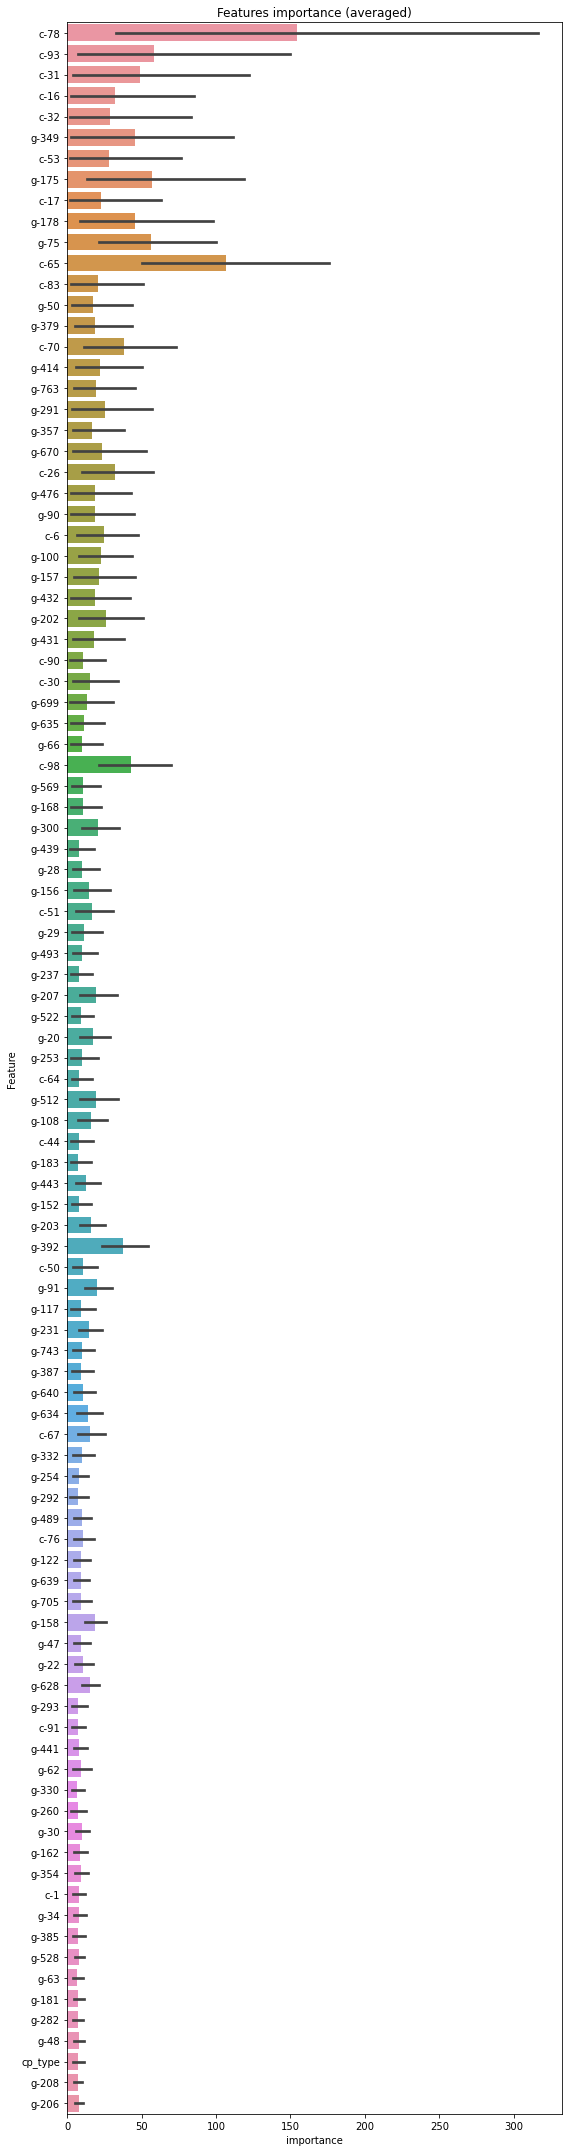

In [70]:
show_feature_importance(feature_importance_df)